In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score
from collections import OrderedDict

In [ ]:
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, Dropout,BatchNormalization
from common.optimizer import RMSProp
from common.util import im2col, col2im 
# from common.SimpleConvNet import SimpleConvNet

In [ ]:
gen_train_data = np.load('./data/G_train_data.npy')
gen_train_label = np.load('./data/G_train_label.npy')

gen_train_data = (gen_train_data - gen_train_data.min()) / gen_train_data.max()
gen_train_data = gen_train_data.astype('float32')

gen_train_data.shape

(12000, 1, 28, 28)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_ConfMat(y_pred,y_test):
  fig = plt.figure(figsize=(10, 10)) # Set Figure

  Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
  Y_test = np.argmax(y_test, 1) # Decode labels

  mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

  # Plot Confusion matrix
  sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
  plt.xlabel('Predicted Values')
  plt.ylabel('True Values');
  plt.show();

In [ ]:
train_data = np.load('./data/train_data.npy')
train_label = np.load('./data/train_label.npy')
print('train_data.shape=', train_data.shape)
print('train_label.shape=', train_label.shape)

gen_train_data = np.load('./data/G_train_data.npy')
gen_train_label = np.load('./data/G_train_label.npy')

# データ正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

gen_train_data = (gen_train_data - gen_train_data.min()) / gen_train_data.max()
gen_train_data = gen_train_data.astype('float32')


# 交差検証のため、データを分割する
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label,test_size=0.2, random_state=234,shuffle=True)
print(X_train.shape,X_test.shape)

x = X_train[:3000,:]
t = y_train[:3000,:]

# 学習のため、データを結合する
# x = np.concatenate([X_train, gen_train_data[:3000]])
# t = np.concatenate([y_train, gen_train_label[:3000]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

X_test = X_test[:3000,:]
y_test = y_test[:3000,:]

x = x.reshape(-1,1,28,28) # 配列形式の変形

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)
(2400, 1, 28, 28) (600, 1, 28, 28)
拡張したデータと結合したｘ (2400, 1, 28, 28)
拡張したデータと結合したｘ (2400, 15)


In [ ]:
def df_gr():  
  df_log = pd.DataFrame({"train_accuracy":train_accuracy,
              "test_accuracy":test_accuracy})

  df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
  plt.ylim([0,1])
  plt.ylabel("Accuracy or loss")
  plt.xlabel("epochs")
  plt.show()

  return df_log

In [ ]:
def train(model,optimizer,epochs,x,t,X_test,y_test):
    snet = model
    epochs = epochs

    batch_size = 32

    xsize = x.shape[0]
    iter_num = np.ceil(xsize / batch_size).astype(np.int)

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for epoch in range(epochs):
        # print("epoch=%s"%epoch)

        # シャッフル
        idx = np.arange(xsize)
        np.random.shuffle(idx)

        for it in range(iter_num):
            """
            ランダムなミニバッチを順番に取り出す
            """
            # print("it=", it)
            mask = idx[batch_size*it : batch_size*(it+1)]

            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]

            # 勾配の計算 (誤差逆伝播法を用いる) 
            grads = snet.gradient(x_train, t_train)

            # 更新
            optimizer.update(snet.params, grads)

        ## 学習経過の記録  
        train_loss.append(snet.loss(x,  t))
        X_test = X_test.reshape(-1,1,28,28)

        l_loss = snet.loss(X_test, y_test)
        test_loss.append(l_loss)
        train_accuracy.append(snet.accuracy(x, t))
        
        t_accuracy = snet.accuracy(X_test, y_test)
        test_accuracy.append(t_accuracy)

        print('t_loss','{:.3f}'.format(l_loss*100),'-------------',',t_acc','{:.3f}'.format(t_accuracy*100))

    df_log = pd.DataFrame({"train_accuracy":train_accuracy,
              "test_accuracy":test_accuracy})

    df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
    plt.ylim([0,1])
    plt.ylabel("Accuracy or loss")
    plt.xlabel("epochs")
    plt.show()

In [ ]:
class Adam:

    # インスタンス変数を定義
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学習率
        self.beta1 = beta1 # mの減衰率
        self.beta2 = beta2 # vの減衰率
        self.iter = 0 # 試行回数を初期化
        self.m = None # モーメンタム
        self.v = None # 適合的な学習係数
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # mとvを初期化
        if self.m is None: # 初回のみ
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 全ての要素が0
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        self.iter += 1 # 更新回数をカウント
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter) # 式(6)の学習率の項
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] # 式(1)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # 式(2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # 式(6)

# 拡張したとしなかったデータを結合する

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# データを読み込む
train_data = np.load('./data/train_data.npy')
train_label = np.load('./data/train_label.npy')
print('train_data.shape=', train_data.shape)
print('train_label.shape=', train_label.shape)

# データ正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

# 交差検証のため、データを分割する
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_label,test_size=0.5, random_state=1234,shuffle=True)
# print(X_train.shape,X_test.shape)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
# test_gen = datagen.flow(X_test, y_test, batch_size=128)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)
(1500, 1, 28, 28) (1500, 1, 28, 28)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1500, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


# 新しい拡張データを生成

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# データを読み込む
train_data = np.load('./data/train_data.npy')
train_label = np.load('./data/train_label.npy')
print('train_data.shape=', train_data.shape)
print('train_label.shape=', train_label.shape)

# データ正規化
train_data = (train_data - train_data.min()) / train_data.max()
train_data = train_data.astype('float32')

# 交差検証のため、データを分割する
# X_train, X_test, y_train, y_test = train_test_split(train_data, train_label,test_size=0.5, random_state=1234,shuffle=True)
# print(X_train.shape,X_test.shape)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
# test_gen = datagen.flow(X_test, y_test, batch_size=128)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
from keras.preprocessing.image import array_to_img,img_to_array

def show(train_gen):
  #表示サイズを設定
  plt.figure(figsize = (10, 5))
  
  #画像をbatch_sizeの数ずつdataに入れる
  #本稿は画像が一枚のため同じ画像がdataに入り続けることになる
  for i, data in enumerate(train_gen):
    #表示のためnumpy配列からimgに変換する
    img=np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
    show_img = img[i].reshape(28,28)

    # show_img = array_to_img(data[0], scale = False)
    #2×3の画像表示の枠を設定＋枠の指定
    plt.subplot(2, 3, i+1)
    #軸を表示しない
    plt.xticks(color = "None")
    plt.yticks(color = "None")
    plt.tick_params(bottom = False, left = False)
    #画像を表示
    plt.imshow(show_img)
    #6回目で繰り返しを強制的に終了
    if i == 5:
      return

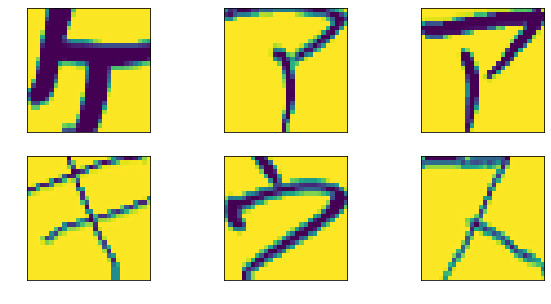

In [ ]:
show(train_gen)

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center = False,#○
    samplewise_center = False,#○
    featurewise_std_normalization = False,#○
    samplewise_std_normalization = False,#○
    zca_whitening = False,
    zca_epsilon = 1e-06,
    rotation_range = 0,#○
    width_shift_range = 0.0,#○
    height_shift_range = 0.0,#○
    brightness_range = None,#○
    shear_range = 0.0,#○
    zoom_range = 0.0,#○
    channel_shift_range = 0.0,#○
    fill_mode = "nearest",#○
    cval = 0.0,#○
    horizontal_flip = False,#○
    vertical_flip = False,#○
    rescale = None,#○
    preprocessing_function = None,#○
    data_format = None,
    validation_split = 0.0,
    dtype = None,
)
train_gen = datagen.flow(X_train, y_train, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
datagen = ImageDataGenerator(
      rotation_range = 0, 
      width_shift_range = 0.1, 
      zoom_range = 0.1,
)
#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
datagen = ImageDataGenerator(
      rotation_range = 2, 
      zoom_range = 0.1,
      height_shift_range=0.1 # randomly shift images vertically (fraction of total height)

)
#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
test_gen = datagen.flow(X_test, y_test, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (600, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


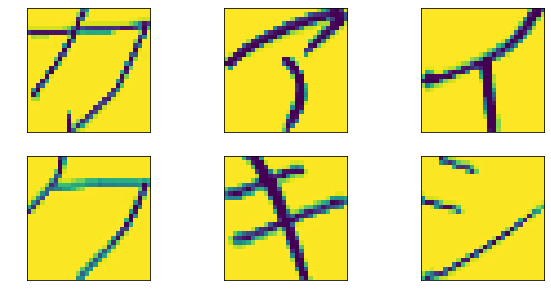

In [ ]:
show(test_gen)

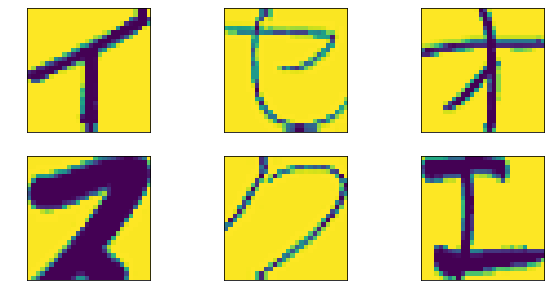

In [ ]:
show(train_gen)

In [ ]:
nx=np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
nt=np.concatenate([train_gen.next()[1] for i in range(train_gen.__len__())])
print(nx.shape)
print(nt.shape)

(2400, 1, 28, 28)
(2400, 15)


In [ ]:
# 新しいデータのをfileに生成する
np.save('data/0806G_data', NG_tdata)
np.save('data/0806G_label', NG_tlabel)

In [ ]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        shear_range = 5,#○
        rotation_range=2,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=True)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


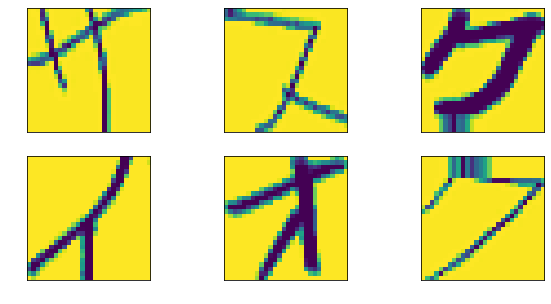

In [ ]:
show(train_gen)

In [ ]:
nx=np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
nt=np.concatenate([train_gen.next()[1] for i in range(train_gen.__len__())])
print(nx.shape)
print(nt.shape)

(2400, 1, 28, 28)
(2400, 15)


In [ ]:
nx_test=np.concatenate([test_gen.next()[0] for i in range(test_gen.__len__())])
nt_test=np.concatenate([test_gen.next()[1] for i in range(test_gen.__len__())])
print(nx_test.shape)
print(nt_test.shape)

(600, 1, 28, 28)
(600, 15)


In [ ]:
NG_tdata = np.concatenate([nx, nx_test])
NG_tlabel = np.concatenate([nt, nt_test])
print(NG_tdata.shape)
print(NG_tlabel.shape)

(3000, 1, 28, 28)
(3000, 15)


In [ ]:
# 元のデータと生成したデータを結合
gen_train_data = np.concatenate([nx[:1000], X_train])
gen_train_label = np.concatenate([nt[:1000], y_train])
print(gen_train_data.shape)
print(gen_train_label.shape)

# 新しいデータのをfileに生成する
# np.save('data/Gen_train_data', gen_train_data)
# np.save('data/Gen_train_label', gen_train_label)

(3400, 1, 28, 28)
(3400, 15)


In [ ]:
train_label.shape

(3000, 15)

In [ ]:
new_gen_train_data = np.concatenate([gen_train_data, train_data])
new_gen_train_label = np.concatenate([gen_train_label, train_label])
print(new_gen_train_data.shape)
print(new_gen_train_label.shape)

(6000, 1, 28, 28)
(6000, 15)


In [ ]:
gen_train_data = np.load('./data/Gen_train_data.npy')
gen_train_label = np.load('./data/Gen_train_label.npy')

In [ ]:
G_train_data = np.concatenate([gen_train_data, new_gen_train_data])
G_train_label = np.concatenate([gen_train_label, new_gen_train_label])
print(G_train_data.shape)
print(G_train_label.shape)

(12000, 1, 28, 28)
(12000, 15)


In [ ]:
# 新しいデータのをfileに生成する
np.save('data/G_train_data', G_train_data)
np.save('data/G_train_label', G_train_label)

In [ ]:
# データを読み込む
train_data = np.load('./data/train_data.npy')
train_label = np.load('./data/train_label.npy')
print('train_data.shape=', train_data.shape)
print('train_label.shape=', train_label.shape)

# データ正規化
# train_data = (train_data - train_data.min()) / train_data.max()
# train_data = train_data.astype('float32')

print("train_data.shape=", train_data.shape)

x = train_data[:3000,:]
t = train_label[:3000,:]

# データ拡張
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        )  # randomly flip images

#datagen.fit(X_train)
train_gen = datagen.flow(x, t, batch_size=128,shuffle=False)
# test_gen = datagen.flow(X_test, y_test, batch_size=128)

nx=np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
nt=np.concatenate([train_gen.next()[1] for i in range(train_gen.__len__())])
print(nx.shape)
print(nt.shape)

# 元のデータと生成したデータを結合
gen_train_data = np.concatenate([x, nx])
gen_train_label = np.concatenate([t, nt])
print(gen_train_data.shape)
print(gen_train_label.shape)

# 新しいデータのをfileに生成する
np.save('data/Gen_train_data', gen_train_data)
np.save('data/Gen_train_label', gen_train_label)

train_data.shape= (3000, 1, 28, 28)
train_label.shape= (3000, 15)
train_data.shape= (3000, 1, 28, 28)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


(3000, 1, 28, 28)
(3000, 15)
(6000, 1, 28, 28)
(6000, 15)


In [ ]:
def plot_GenData(x,t):
  y_test = t
  X_test__ = x.reshape(x.shape[0], 28, 28)

  fig, axis = plt.subplots(4, 4, figsize=(12, 14))
  for i, ax in enumerate(axis.flat):
      ax.imshow(X_test__[i], cmap='binary')
      ax.set(title = f"Real Number is {y_test[i].argmax()}");

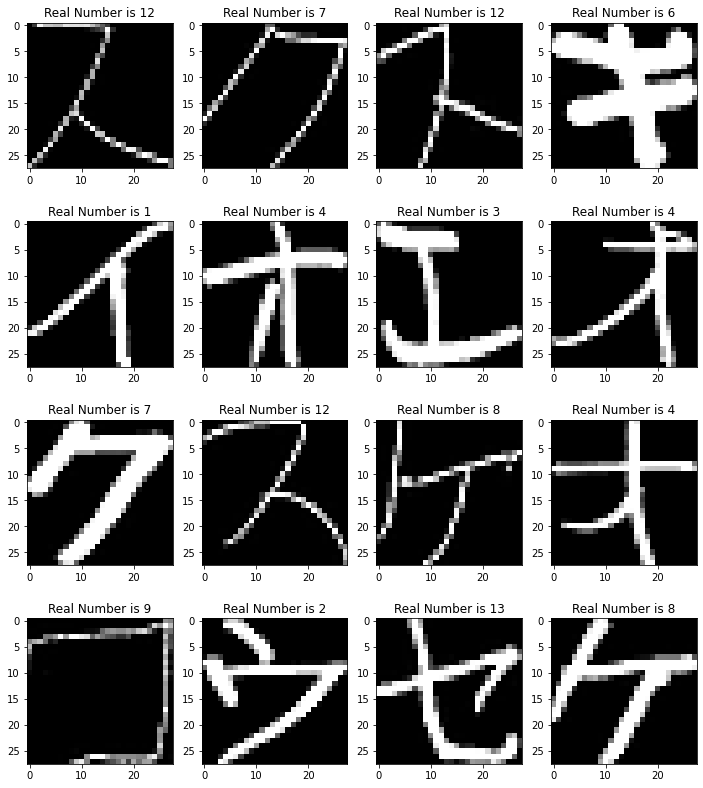

In [ ]:
plot_GenData(x,t)

In [ ]:
type(train_gen)

keras.preprocessing.image.NumpyArrayIterator

# 小さなフィルターModel 95%

In [ ]:
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, Dropout,BatchNormalization
from common.optimizer import RMSProp
from common.util import im2col, col2im

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import OrderedDict

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']

        filter_num2 = conv_param['filter_num2']
        filter_num3 = conv_param['filter_num3']
        hidden_size2 = 128
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        # pool_output_pixel = filter_num3 * pool_output_size * pool_output_size # プーリング後のピクセル総数
        pool_output_pixel = 3136

        # Heを使う
        pre_node_nums = np.array([filter_num*input_dim[0]*filter_num,
                                  filter_num2*filter_num3*filter_num,
                                  filter_num2*filter_num3*filter_num,
                                  filter_num3*filter_num2*filter_num,
                                  filter_num3*filter_num2,
                                  pool_output_pixel,
                                  hidden_size
                                  ])
        wi_scales = np.sqrt(2/pre_node_nums)

        # 重みの初期化
        self.params = {}
        std = weight_init_std
        # 64
        self.params['W1'] = wi_scales[0] * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W12'] = wi_scales[1] * np.random.randn(filter_num, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b12'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        # 128
        self.params['W21'] = wi_scales[2] * np.random.randn(filter_num2, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b21'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        self.params['W22'] = wi_scales[3] * np.random.randn(filter_num2, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b22'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        # 256
        self.params['W31'] = wi_scales[4] * np.random.randn(filter_num3, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b31'] = np.zeros(filter_num3) #b1は畳み込みフィルターのバイアスになる


        self.params['W2'] = wi_scales[5] *  np.random.randn(pool_output_pixel, hidden_size)
        print(wi_scales[1],pool_output_pixel,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = wi_scales[2] *  np.random.randn(hidden_size, hidden_size2)
        self.params['b3'] = np.zeros(hidden_size2)
        self.params['W4'] = wi_scales[6] *  np.random.randn(hidden_size2, output_size)
        self.params['b4'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        
        self.layers['Conv2'] = Convolution(self.params['W12'], self.params['b12'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv3'] = Convolution(self.params['W21'], self.params['b21'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU3'] = ReLU()
        
        self.layers['Conv4'] = Convolution(self.params['W22'], self.params['b22'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU4'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv5'] = Convolution(self.params['W31'], self.params['b31'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU5'] = ReLU()
        # self.layers['Pool3'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU2'] = ReLU()
        self.layers['Dropout1'] = Dropout(dropout_ratio=0.5)
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['ReLU4'] = ReLU()
        self.layers['Dropout2'] = Dropout(dropout_ratio=0.5)
        self.layers['Affine3'] = Affine(self.params['W4'], self.params['b4'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            # print('predict x.shape',x.shape)

        return x

    def loss(self, x, t):
        """
        損失関数
        """        
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        # print('dout.shape',dout.shape)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # print('layer.backward(dout)',dout.shape)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W21'], grads['b21'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W22'], grads['b22'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['W31'], grads['b31'] = self.layers['Conv5'].dW, self.layers['Conv5'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [ ]:
# CNNのオブジェクト生成
# 95.167
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=128, output_size=15, weight_init_std=0.01)

epochs = 10
batch_size = 32
model = snet

xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)


optimizer = RMSProp(lr=0.0001, rho=0.88)

train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

0.0078125 3136 128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


t_loss 189.179 ------------- ,t_acc 57.833
t_loss 111.053 ------------- ,t_acc 75.000
t_loss 72.190 ------------- ,t_acc 85.000
t_loss 51.409 ------------- ,t_acc 88.333
t_loss 38.409 ------------- ,t_acc 88.833
t_loss 33.030 ------------- ,t_acc 91.167
t_loss 28.040 ------------- ,t_acc 92.833
t_loss 25.086 ------------- ,t_acc 94.167
t_loss 23.840 ------------- ,t_acc 94.833
t_loss 21.936 ------------- ,t_acc 95.167


In [ ]:
epochs = 5
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 19.217 ------------- ,t_acc 95.500
t_loss 18.112 ------------- ,t_acc 94.167
t_loss 18.307 ------------- ,t_acc 94.833
t_loss 21.071 ------------- ,t_acc 95.000
t_loss 18.339 ------------- ,t_acc 94.667


In [ ]:
x.shape

(2400, 1, 28, 28)

In [ ]:
epochs = 10
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 35.241 ------------- ,t_acc 88.833
t_loss 28.135 ------------- ,t_acc 90.667
t_loss 28.462 ------------- ,t_acc 90.000
t_loss 36.157 ------------- ,t_acc 88.833
t_loss 55.909 ------------- ,t_acc 83.667
t_loss 33.914 ------------- ,t_acc 90.500
t_loss 59.338 ------------- ,t_acc 83.667
t_loss 51.758 ------------- ,t_acc 84.667
t_loss 47.721 ------------- ,t_acc 88.500
t_loss 44.246 ------------- ,t_acc 89.333


In [ ]:
# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=128, output_size=15, weight_init_std=0.01)

epochs = 10
batch_size = 32
model = snet

xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)


optimizer = RMSProp(lr=0.0001, rho=0.88)

train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

0.0078125 576 128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


loss,test_accuracy 2.081027147230409 0.6872222222222222
loss,test_accuracy 1.8797018527909277 0.7572222222222222
loss,test_accuracy 1.7052748697651885 0.8261111111111111
loss,test_accuracy 1.5888040297394799 0.8516666666666667
loss,test_accuracy 1.4832057157379839 0.8855555555555555
loss,test_accuracy 1.4388582762306883 0.8866666666666667
loss,test_accuracy 1.3867928904082996 0.8955555555555555
loss,test_accuracy 1.3278743769678014 0.9227777777777778
loss,test_accuracy 1.2887276702629429 0.9172222222222223
loss,test_accuracy 1.2643667643054293 0.9161111111111111


# 7200コのデータを学習させる

In [ ]:
# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=128, output_size=15, weight_init_std=0.01)

epochs = 10
batch_size = 32
model = snet

xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# Adamを使う
optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam

train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

0.0078125 576 128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


loss,test_accuracy 2.040582993717052 0.7044444444444444
loss,test_accuracy 1.8016823167056055 0.8005555555555556
loss,test_accuracy 1.6212087624494587 0.8344444444444444
loss,test_accuracy 1.4897844311561654 0.8827777777777778
loss,test_accuracy 1.435098747726265 0.8911111111111111
loss,test_accuracy 1.3695053119878313 0.9172222222222223
loss,test_accuracy 1.3195953319789602 0.9166666666666666
loss,test_accuracy 1.28120458509358 0.9255555555555556
loss,test_accuracy 1.2331600610847306 0.9288888888888889
loss,test_accuracy 1.2128417379090366 0.9283333333333333


In [ ]:
# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=64, output_size=15, weight_init_std=0.01)

epochs = 10
batch_size = 32
model = snet

xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# Adamを使う
optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam

train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

0.0078125 576 64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


loss,test_accuracy 2.2752046343375594 0.585
loss,test_accuracy 1.9626027217457345 0.7394444444444445
loss,test_accuracy 1.7496142368087582 0.8305555555555556
loss,test_accuracy 1.61694581320893 0.8527777777777777
loss,test_accuracy 1.5201078878398797 0.8933333333333333
loss,test_accuracy 1.4590967352647923 0.8844444444444445
loss,test_accuracy 1.390421997341117 0.9166666666666666
loss,test_accuracy 1.3511085736995156 0.9238888888888889
loss,test_accuracy 1.324859762699754 0.9216666666666666
loss,test_accuracy 1.2885331685142423 0.9261111111111111


In [ ]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(snet, f)

In [ ]:
epochs = 50
train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

loss,test_accuracy 1.2548181886821352 0.9288888888888889
loss,test_accuracy 1.2234230004555466 0.9372222222222222
loss,test_accuracy 1.2043088687674537 0.935
loss,test_accuracy 1.17235140453415 0.9511111111111111
loss,test_accuracy 1.1393904428452928 0.9411111111111111
loss,test_accuracy 1.1241066387789735 0.9416666666666667
loss,test_accuracy 1.0930490403229165 0.94
loss,test_accuracy 1.0731317086827967 0.935
loss,test_accuracy 1.0309658479810713 0.9472222222222222
loss,test_accuracy 1.0166592801102043 0.955
loss,test_accuracy 0.9840124888509123 0.9433333333333334
loss,test_accuracy 0.9479957572005321 0.9544444444444444
loss,test_accuracy 0.9101786339060527 0.9405555555555556
loss,test_accuracy 0.885621094635749 0.9527777777777777
loss,test_accuracy 0.8423261682572881 0.9605555555555556
loss,test_accuracy 0.8343674906218916 0.9355555555555556
loss,test_accuracy 0.7980173322718334 0.9211111111111111
loss,test_accuracy 0.7624421320060429 0.9388888888888889
loss,test_accuracy 0.748614735

In [ ]:
x.shape

(7200, 1, 28, 28)

In [ ]:
X_test.shape

(1800, 784)

In [ ]:
def plot_pred(x):
  y_pred = snet.predict(x)
  X_test__ = x.reshape(x.shape[0], 28, 28)

  fig, axis = plt.subplots(4, 4, figsize=(12, 14))
  for i, ax in enumerate(axis.flat):
      ax.imshow(X_test__[i], cmap='binary')
      ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

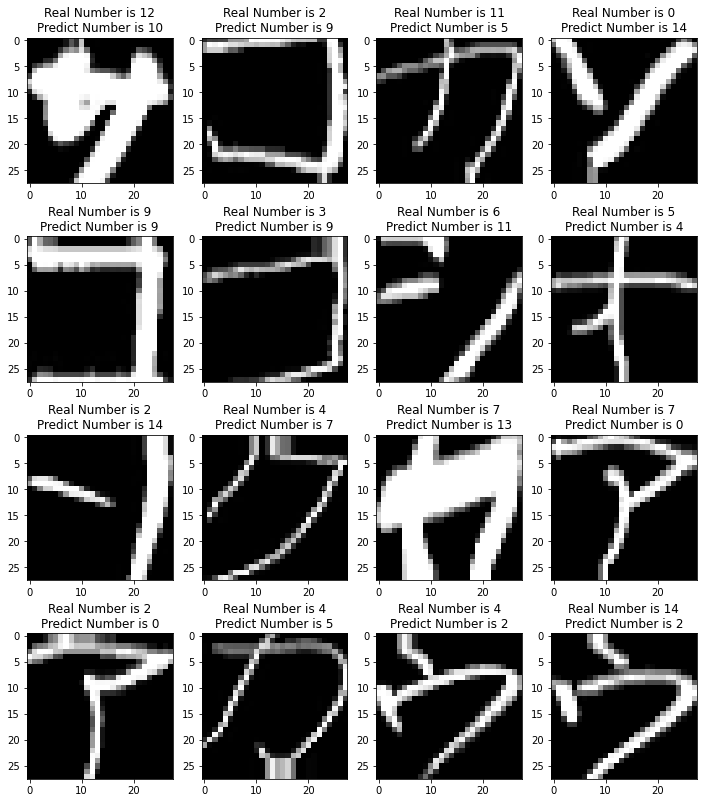

In [ ]:
# 拡張したデータの予測
plot_pred(x)

In [ ]:
import numpy as np
import glob
import os,sys
# import util
import pickle
from common.SimpleConvNet import *

def makedataset():
    """
    データセットをつくる関数です。
    自由に編集してください。
    """
    
    # 次の行は変更しないこと
    test_data= loaddata()
    
    # 以下は自由に編集しても構いません
    # 必要な前処理をここに記述してください  
    
    # 正規化
    test_data = test_data / test_data.max()
    test_data = test_data.astype('float32')

    # 配列形式変更
    test_data = test_data.reshape(-1, 28*28)

    return test_data


def func_predict(test_data, test_label):
    """
    予測する関数
    data : 画像データ
    return loss, accuracy
    引数とreturn以外は、自由に編集してください    
    """
    
    # 以下を自由に編集してください
    test_data = test_data[:3000,:]
    test_label = test_label[:3000,:]

    test_data = test_data.reshape(-1,1,28,28) # 配列形式の変形
    
    with open("katakana_model.pickle", "rb") as f:
        model = pickle.load(f)
    
    accuracy = model.accuracy(test_data, test_label)
    loss  = model.loss(test_data, test_label)
    
    return loss, accuracy # 編集不可


def main():
    """
    編集しないでください。
    """
    # テスト用データをつくる
    test_data = makedataset()

    # 予測し精度を算出する
    accuracy(func_predict, test_data)
    
    return

if __name__=="__main__":
    main()

0
0.03932103846522027 0.974
1
0.02337602143079218 0.982
2
0.016501249890742444 0.968
3
0.09145574194745915 0.94
4
0.11545335756227205 0.858
5
0.07766723431353788 0.934
Test loss: 0.06062910726833733
Test accuracy: 0.9426666666666667


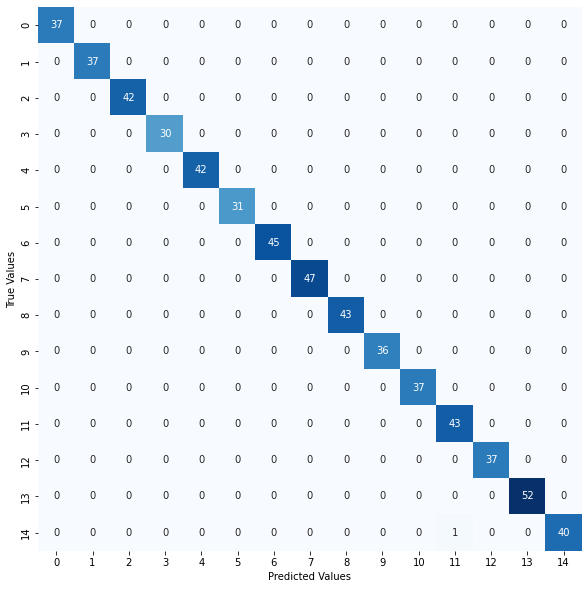

In [ ]:
y_pred = snet.predict(X_test)
plot_ConfMat(y_pred,y_test)

In [ ]:
import numpy as np
import glob
import os,sys
# import util
import pickle
from common.SimpleConvNet import *
from sklearn.metrics import confusion_matrix

def makedataset():
    """
    データセットをつくる関数です。
    自由に編集してください。
    """
    
    # 次の行は変更しないこと
    test_data= loaddata()
    
    # 以下は自由に編集しても構いません
    # 必要な前処理をここに記述してください  
    
    # 正規化
    test_data = test_data / test_data.max()
    test_data = test_data.astype('float32')

    # 配列形式変更
    test_data = test_data.reshape(-1, 28*28)

    return test_data


def func_predict(test_data, test_label):
    """
    予測する関数
    data : 画像データ
    return loss, accuracy
    引数とreturn以外は、自由に編集してください    
    """
    
    # 以下を自由に編集してください
    test_data = test_data[:3000,:]
    test_label = test_label[:3000,:]

    test_data = test_data.reshape(-1,1,28,28) # 配列形式の変形
    
    with open("katakana_model.pickle", "rb") as f:
        model = pickle.load(f)
    
    accuracy = model.accuracy(test_data, test_label)
    loss  = model.loss(test_data, test_label)

    # plot_ConfMat(test_data, test_label)
    
    return loss, accuracy # 編集不可

def plot_ConfMat(test_data, test_label):
    fig = plt.figure(figsize=(10, 10)) # Set Figure

    y_test = test_label
    y_pred = func_predict # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

    Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
    Y_test = np.argmax(y_test, 1) # Decode labels

    mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

    # Plot Confusion matrix
    sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values');
    plt.show();

def main():
    """
    編集しないでください。
    """
    # テスト用データをつくる
    test_data = makedataset()

    # 予測し精度を算出する
    accuracy(func_predict, test_data)
    
    return

main()

# if __name__=="__main__":
#     main()

0


EOFError: ignored

In [ ]:
import numpy as np

def loaddata():
    """
    データを読む関数
    """
    test_data = np.load("./data/train_data.npy")
    return test_data



def accuracy(func_predict, test_data):
    """
    精度を計算する関数
    label_pred : numpy 1D array 
    """
    
    # データ数のチェック
    data_size = len(test_data)
    if data_size<3000:
        error = "label_predのサイズが足りていません"
        print(data_size, error)
        print('Test loss:', error)
        print('Test accuracy:', error)
        return
    elif data_size>3000:
        error = "label_predのサイズが多すぎます"
        print(data_size, error)
        print('Test loss:', error)
        print('Test accuracy:', error)        
        return

    test_label = np.load("./data/train_label.npy")
    
    
    # 予測
    # サーバーへの負荷を軽減するため、ミニバッチ処理で行う
    
    batch_size = 500
    
    minibatch_num = np.ceil( data_size / batch_size).astype(int) # ミニバッチの個数
    
    li_loss = []
    li_accuracy = []
    li_num = []
    index = np.arange(data_size)
    
    for mn in range(minibatch_num):
        print(mn)
        mask = index[batch_size*mn:batch_size*(mn+1)]        
        data = test_data[mask]
        label = test_label[mask]
        loss, accuracy  = func_predict(data, label)
        print(loss, accuracy)
        
        li_loss.append(loss)
        li_accuracy.append(accuracy)
        li_num.append(len(data))

    test_loss = np.dot(li_loss, li_num) / np.sum(li_num)
    test_accuracy = np.dot(li_accuracy, li_num) / np.sum(li_num)
    
    print('Test loss:', test_loss)
    print('Test accuracy:', test_accuracy)
    return

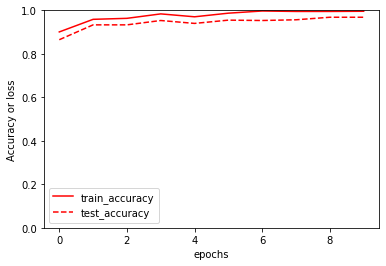

,train_accuracy,test_accuracy
0,0.900833,0.865000
1,0.958750,0.933333
2,0.963333,0.933333
3,0.983750,0.953333
4,0.970417,0.940000
5,0.987083,0.955000
6,0.997083,0.953333
7,0.995000,0.956667
8,0.995000,0.968333
9,0.995833,0.968333


In [ ]:
# 'filter_num':32,
# filter_num2 = 64
# filter_num3 = 128
# optimizer = RMSProp(lr=0.001, rho=0.88)
df_gr()

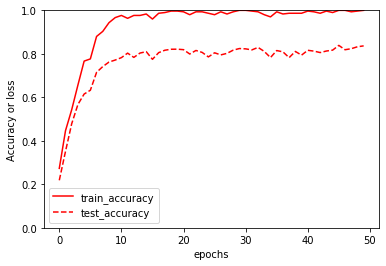

,train_accuracy,test_accuracy
0,0.273333,0.218519
1,0.446667,0.351481
2,0.543333,0.478889
3,0.656667,0.567407
4,0.766667,0.615185
5,0.776667,0.632593
6,0.880000,0.714815
7,0.903333,0.741481
8,0.943333,0.762222
9,0.966667,0.771481


In [ ]:
df_gr()

In [ ]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(snet, f)

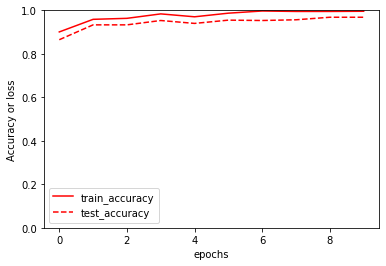

,train_accuracy,test_accuracy
0,0.900833,0.865000
1,0.958750,0.933333
2,0.963333,0.933333
3,0.983750,0.953333
4,0.970417,0.940000
5,0.987083,0.955000
6,0.997083,0.953333
7,0.995000,0.956667
8,0.995000,0.968333
9,0.995833,0.968333


In [ ]:
df_gr()

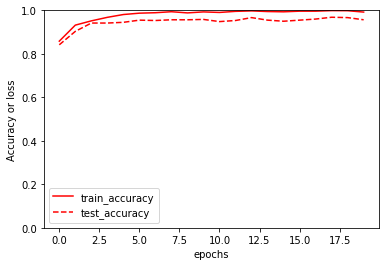

,train_accuracy,test_accuracy
0,0.858333,0.841667
1,0.932083,0.903333
2,0.951667,0.941667
3,0.967917,0.941667
4,0.980833,0.945000
5,0.987083,0.955000
6,0.989167,0.953333
7,0.993750,0.956667
8,0.988333,0.956667
9,0.992917,0.958333


In [ ]:
df_gr()

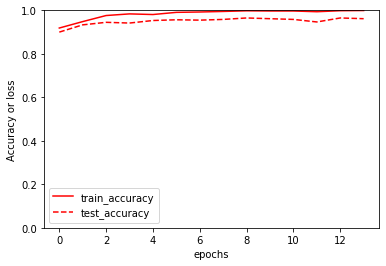

,train_accuracy,test_accuracy
0,0.918750,0.900000
1,0.948333,0.933333
2,0.976250,0.945000
3,0.983750,0.941667
4,0.980833,0.953333
5,0.990833,0.956667
6,0.992500,0.955000
7,0.995000,0.958333
8,0.997917,0.965000
9,0.997083,0.961667


In [ ]:
df_gr()

# RAM足りないModel

In [ ]:
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, Dropout,BatchNormalization
from common.optimizer import RMSProp
from common.util import im2col, col2im

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import OrderedDict

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':32, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=128, output_size=10, weight_init_std=0.01):
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']

        filter_num2 = 128
        filter_num3 = 256
        hidden_size2 = 64
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = filter_num2 * pool_output_size * pool_output_size # プーリング後のピクセル総数

        # Heを使う
        pre_node_nums = np.array([filter_num*input_dim[0]*filter_num,
                                  filter_num2*filter_num2*filter_num,
                                  filter_num2*filter_num3*filter_num,
                                  filter_num3*filter_num3*filter_num,
                                  filter_num3*filter_num3,
                                  pool_output_pixel,
                                  hidden_size
                                  ])
        wi_scales = np.sqrt(2/pre_node_nums)

        # 重みの初期化
        self.params = {}
        std = weight_init_std
        # 64
        self.params['W1'] = wi_scales[0] * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W12'] = wi_scales[1] * np.random.randn(filter_num, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b12'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        # 128
        self.params['W21'] = wi_scales[2] * np.random.randn(filter_num2, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b21'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        self.params['W22'] = wi_scales[3] * np.random.randn(filter_num2, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b22'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        # 256
        self.params['W31'] = wi_scales[4] * np.random.randn(filter_num3, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b31'] = np.zeros(filter_num3) #b1は畳み込みフィルターのバイアスになる


        self.params['W2'] = wi_scales[5] *  np.random.randn(2304, hidden_size)
        print(wi_scales[1],pool_output_pixel,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # self.params['W3'] = wi_scales[2] *  np.random.randn(hidden_size, hidden_size2)
        # self.params['b3'] = np.zeros(hidden_size2)
        self.params['W4'] = wi_scales[6] *  np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        
        self.layers['Conv2'] = Convolution(self.params['W12'], self.params['b12'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv3'] = Convolution(self.params['W21'], self.params['b21'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU3'] = ReLU()
        
        self.layers['Conv4'] = Convolution(self.params['W22'], self.params['b22'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU4'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv5'] = Convolution(self.params['W31'], self.params['b31'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU5'] = ReLU()
        self.layers['Pool3'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1,beta=0)


        # self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)

        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        # self.layers['BatchNorm'] = BatchNormalization(gamma=1,beta=0)
        self.layers['ReLU2'] = ReLU()
        self.layers['Dropout1'] = Dropout(dropout_ratio=0.5)
        # self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        # self.layers['ReLU4'] = ReLU()
        self.layers['Affine3'] = Affine(self.params['W4'], self.params['b4'])

        print("self.params['W1']",self.params['W1'].shape)
        print("self.params['W12']",self.params['W12'].shape)
        print("self.params['W2']",self.params['W2'].shape)
        # print("self.params['W3']",self.params['W3'].shape)
        print("self.params['W4']",self.params['W4'].shape)

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            # print('predict x.shape',x.shape)

        return x

    def loss(self, x, t):
        """
        損失関数
        """        
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        # print('dout.shape',dout.shape)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # print('layer.backward(dout)',dout.shape)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W21'], grads['b21'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W22'], grads['b22'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['W31'], grads['b31'] = self.layers['Conv5'].dW, self.layers['Conv5'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        # grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [ ]:
class Adam:

    # インスタンス変数を定義
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学習率
        self.beta1 = beta1 # mの減衰率
        self.beta2 = beta2 # vの減衰率
        self.iter = 0 # 試行回数を初期化
        self.m = None # モーメンタム
        self.v = None # 適合的な学習係数
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # mとvを初期化
        if self.m is None: # 初回のみ
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 全ての要素が0
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        self.iter += 1 # 更新回数をカウント
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter) # 式(6)の学習率の項
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] # 式(1)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # 式(2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # 式(6)

In [ ]:
epochs = 14
batch_size = 128

# optimizer = RMSProp(lr=0.001, rho=0.9)
optimizer = Adam(lr=0.01, beta1=0.8, beta2=0.98) #Adam

# 繰り返し回数
xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)


# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num2':128,'filter_num':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=512, output_size=15, weight_init_std=0.01)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    # print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        # print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # print('x_train.shape',x_train.shape)
        # print('t_train.shape',t_train.shape)
        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録  
    l_loss = snet.loss(x,  t)

    train_loss.append(l_loss)
    X_test = X_test.reshape(-1,1,28,28)
    test_loss.append(snet.loss(X_test, y_test))
    train_accuracy.append(snet.accuracy(x, t))
    
    t_accuracy = snet.accuracy(X_test, y_test)
    test_accuracy.append(t_accuracy)

    print('loss,test_accuracy',l_loss, t_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


0.015625 25088 512
self.params['W1'] (64, 1, 3, 3)
self.params['W12'] (64, 64, 3, 3)
self.params['W2'] (2304, 512)
self.params['W4'] (512, 15)


In [ ]:
'''
self.params['W1'] (64, 1, 3, 3)
self.params['W2'] (12544, 128)
self.params['W4'] (128, 15)
dout.shape (30, 15) softmax
layer.backward(dout) (30, 128) affine2
layer.backward(dout) (30, 128) relu
layer.backward(dout) (30, 128) affine1
layer.backward(dout) (30, 64, 12, 12) pooling
layer.backward(dout) (30, 64, 12, 12) conv
layer.backward(dout) (30, 64, 14, 14) batchNorm
layer.backward(dout) (30, 64, 14, 14) pooling
layer.backward(dout) (30, 64, 28, 28) relu
layer.backward(dout) (30, 64, 28, 28) conv
layer.backward(dout) (30, 1, 28, 28) input
'''
df_gr()

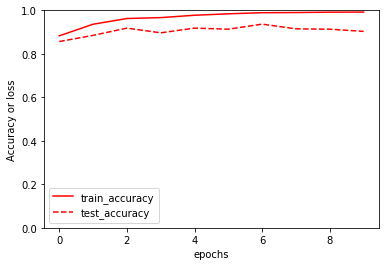

,train_accuracy,test_accuracy
0,0.882917,0.856667
1,0.936250,0.885000
2,0.962500,0.918333
3,0.966667,0.896667
4,0.977500,0.918333
5,0.984167,0.913333
6,0.989167,0.936667
7,0.990000,0.915000
8,0.991667,0.913333
9,0.992083,0.903333


In [ ]:
'''
dout.shape (32, 15) softmax
layer.backward(dout) (32, 128) affine2
layer.backward(dout) (32, 128) relu
layer.backward(dout) (32, 128) affine1
layer.backward(dout) (32, 32, 14, 14) batchNorm
layer.backward(dout) (32, 32, 14, 14) pooling
layer.backward(dout) (32, 32, 28, 28) relu
layer.backward(dout) (32, 32, 28, 28) conv
layer.backward(dout) (32, 1, 28, 28)  input
'''
df_gr()

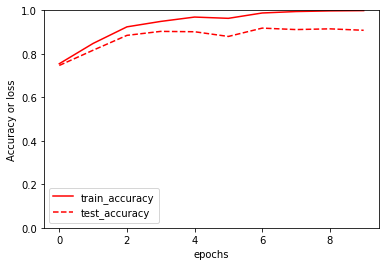

,train_accuracy,test_accuracy
0,0.754583,0.746667
1,0.847917,0.816667
2,0.924167,0.885000
3,0.949167,0.903333
4,0.969167,0.901667
5,0.963333,0.880000
6,0.987917,0.918333
7,0.994583,0.911667
8,0.997500,0.915000
9,0.998750,0.908333


In [ ]:
df_gr()

# うまく行ったModel

In [ ]:
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, Dropout,BatchNormalization
from common.optimizer import RMSProp
from common.util import im2col, col2im

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import OrderedDict

class SimpleConvNet1:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':32, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=128, output_size=10, weight_init_std=0.01):
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']

        filter_num2 = 64
        hidden_size2 = 64
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = filter_num2 * pool_output_size * pool_output_size # プーリング後のピクセル総数

        # Heを使う
        pre_node_nums = np.array([filter_num*input_dim[0]*filter_num,
                                  filter_num2*input_dim[0]*filter_num,
                                  pool_output_pixel,
                                  hidden_size,
                                  hidden_size
                                  ])
        wi_scales = np.sqrt(2/pre_node_nums)

        # 重みの初期化
        self.params = {}
        std = weight_init_std
        self.params['W1'] = wi_scales[0] * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W12'] = wi_scales[0] * np.random.randn(filter_num2, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b12'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        self.params['W2'] = wi_scales[1] *  np.random.randn(3136, hidden_size)
        print(wi_scales[1],pool_output_pixel,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        # self.params['W3'] = wi_scales[2] *  np.random.randn(hidden_size, hidden_size2)
        # self.params['b3'] = np.zeros(hidden_size2)
        self.params['W4'] = wi_scales[2] *  np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['BatchNorm1'] = BatchNormalization(gamma=1,beta=0)
        self.layers['ReLU1'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        self.layers['Conv2'] = Convolution(self.params['W12'], self.params['b12'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1,beta=0)
        self.layers['ReLU21'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)

        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        # self.layers['BatchNorm'] = BatchNormalization(gamma=1,beta=0)
        self.layers['ReLU2'] = ReLU()
        self.layers['Dropout1'] = Dropout(dropout_ratio=0.5)
        # self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        # self.layers['ReLU4'] = ReLU()
        self.layers['Affine3'] = Affine(self.params['W4'], self.params['b4'])

        print("self.params['W1']",self.params['W1'].shape)
        print("self.params['W12']",self.params['W12'].shape)
        print("self.params['W2']",self.params['W2'].shape)
        # print("self.params['W3']",self.params['W3'].shape)
        print("self.params['W4']",self.params['W4'].shape)

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            # print('predict x.shape',x.shape)

        return x

    def loss(self, x, t):
        """
        損失関数
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        # print('dout.shape',dout.shape)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            print('layer.backward(dout)',dout.shape)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        # grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

# NumPyCNN https://github.com/ahmedfgad/NumPyCNN/blob/master/example.py

In [ ]:
import numpy
import sys

class numpycnn:
    def conv_(img, conv_filter):
        filter_size = conv_filter.shape[1]
        result = numpy.zeros((img.shape))
        #Looping through the image to apply the convolution operation.
        for r in numpy.uint16(numpy.arange(filter_size/2.0, 
                              img.shape[0]-filter_size/2.0+1)):
            for c in numpy.uint16(numpy.arange(filter_size/2.0, 
                                              img.shape[1]-filter_size/2.0+1)):
                """
                Getting the current region to get multiplied with the filter.
                How to loop through the image and get the region based on 
                the image and filer sizes is the most tricky part of convolution.
                """
                curr_region = img[r-numpy.uint16(numpy.floor(filter_size/2.0)):r+numpy.uint16(numpy.ceil(filter_size/2.0)), 
                                  c-numpy.uint16(numpy.floor(filter_size/2.0)):c+numpy.uint16(numpy.ceil(filter_size/2.0))]
                #Element-wise multipliplication between the current region and the filter.
                curr_result = curr_region * conv_filter
                conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.
                result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
                
        #Clipping the outliers of the result matrix.
        final_result = result[numpy.uint16(filter_size/2.0):result.shape[0]-numpy.uint16(filter_size/2.0), 
                              numpy.uint16(filter_size/2.0):result.shape[1]-numpy.uint16(filter_size/2.0)]
        return final_result
    def conv(img, conv_filter):

        if len(img.shape) != len(conv_filter.shape) - 1: # Check whether number of dimensions is the same
            print("Error: Number of dimensions in conv filter and image do not match.")  
            exit()
        if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
            if img.shape[-1] != conv_filter.shape[-1]:
                print("Error: Number of channels in both image and filter must match.")
                sys.exit()
        if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
            print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
            sys.exit()
        if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
            print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
            sys.exit()

        # An empty feature map to hold the output of convolving the filter(s) with the image.
        feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                    img.shape[1]-conv_filter.shape[1]+1, 
                                    conv_filter.shape[0]))

        # Convolving the image by the filter(s).
        for filter_num in range(conv_filter.shape[0]):
            print("Filter ", filter_num + 1)
            curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
            """ 
            Checking if there are mutliple channels for the single filter.
            If so, then each channel will convolve the image.
            The result of all convolutions are summed to return a single feature map.
            """
            if len(curr_filter.shape) > 2:
                conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
                for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                    conv_map = conv_map + conv_(img[:, :, ch_num], 
                                      curr_filter[:, :, ch_num])
            else: # There is just a single channel in the filter.
                conv_map = conv_(img, curr_filter)
            feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
        return feature_maps # Returning all feature maps.
        

    def pooling(feature_map, size=2, stride=2):
        #Preparing the output of the pooling operation.
        pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride+1),
                                numpy.uint16((feature_map.shape[1]-size+1)/stride+1),
                                feature_map.shape[-1]))
        for map_num in range(feature_map.shape[-1]):
            r2 = 0
            for r in numpy.arange(0,feature_map.shape[0]-size+1, stride):
                c2 = 0
                for c in numpy.arange(0, feature_map.shape[1]-size+1, stride):
                    pool_out[r2, c2, map_num] = numpy.max([feature_map[r:r+size,  c:c+size, map_num]])
                    c2 = c2 + 1
                r2 = r2 +1
        return pool_out

    def relu(feature_map):
        #Preparing the output of the ReLU activation function.
        relu_out = numpy.zeros(feature_map.shape)
        for map_num in range(feature_map.shape[-1]):
            for r in numpy.arange(0,feature_map.shape[0]):
                for c in numpy.arange(0, feature_map.shape[1]):
                    relu_out[r, c, map_num] = numpy.max([feature_map[r, c, map_num], 0])
        return relu_out

In [ ]:
import skimage.data
import numpy
import matplotlib
# import NumPyCNN as numpycnn


# Reading the image
#img = skimage.io.imread("test.jpg")
#img = skimage.data.checkerboard()
img = skimage.data.chelsea()
#img = skimage.data.camera()

# Converting the image into gray.
img = skimage.color.rgb2gray(img)

# First conv layer
#l1_filter = numpy.random.rand(2,7,7)*20 # Preparing the filters randomly.
l1_filter = numpy.zeros((2,3,3))
l1_filter[0, :, :] = numpy.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
l1_filter[1, :, :] = numpy.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])

print("\n**Working with conv layer 1**")
l1_feature_map = numpycnn.conv(img, l1_filter)
print("\n**ReLU**")
l1_feature_map_relu = numpycnn.relu(l1_feature_map)
print("\n**Pooling**")
l1_feature_map_relu_pool = numpycnn.pooling(l1_feature_map_relu, 2, 2)
print("**End of conv layer 1**\n")

# Second conv layer
l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 2**")
l2_feature_map = numpycnn.conv(l1_feature_map_relu_pool, l2_filter)
print("\n**ReLU**")
l2_feature_map_relu = numpycnn.relu(l2_feature_map)
print("\n**Pooling**")
l2_feature_map_relu_pool = numpycnn.pooling(l2_feature_map_relu, 2, 2)
print("**End of conv layer 2**\n")

# Third conv layer
l3_filter = numpy.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])
print("\n**Working with conv layer 3**")
l3_feature_map = numpycnn.conv(l2_feature_map_relu_pool, l3_filter)
print("\n**ReLU**")
l3_feature_map_relu = numpycnn.relu(l3_feature_map)
print("\n**Pooling**")
l3_feature_map_relu_pool = numpycnn.pooling(l3_feature_map_relu, 2, 2)
print("**End of conv layer 3**\n")

# Graphing results
fig0, ax0 = matplotlib.pyplot.subplots(nrows=1, ncols=1)
ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])
matplotlib.pyplot.savefig("in_img.png", bbox_inches="tight")
matplotlib.pyplot.close(fig0)

# Layer 1
fig1, ax1 = matplotlib.pyplot.subplots(nrows=3, ncols=2)
ax1[0, 0].imshow(l1_feature_map[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_map[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

matplotlib.pyplot.savefig("L1.png", bbox_inches="tight")
matplotlib.pyplot.close(fig1)

# Layer 2
fig2, ax2 = matplotlib.pyplot.subplots(nrows=3, ncols=3)
ax2[0, 0].imshow(l2_feature_map[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_map[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_map[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_map_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")

matplotlib.pyplot.savefig("L2.png", bbox_inches="tight")
matplotlib.pyplot.close(fig2)

# Layer 3
fig3, ax3 = matplotlib.pyplot.subplots(nrows=1, ncols=3)
ax3[0].imshow(l3_feature_map[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")

matplotlib.pyplot.savefig("L3.png", bbox_inches="tight")
matplotlib.pyplot.close(fig3)


**Working with conv layer 1**
Filter  1
Filter  2

**ReLU**

**Pooling**
**End of conv layer 1**


**Working with conv layer 2**
Filter  1
Filter  2
Filter  3

**ReLU**

**Pooling**
**End of conv layer 2**


**Working with conv layer 3**
Filter  1

**ReLU**

**Pooling**
**End of conv layer 3**



In [ ]:
x = np.random.randn(30,3*3)
x.shape

(30, 9)

In [ ]:
x.reshape(-1,1,3,3)
x[:2]

array([[ 0.78054155,  0.73206818,  0.01005461,  0.39807526,  3.24248256,
        -0.74052928,  1.16505199, -1.51903934, -1.79883882],
       [-1.787957  ,  0.50456309, -1.55275768,  0.06922997,  0.55528672,
         0.29328232,  0.4908466 , -2.89948674,  1.4343381 ]])

In [ ]:
x.reshape(-1,3,3,1)
x[:2]

array([[ 0.78054155,  0.73206818,  0.01005461,  0.39807526,  3.24248256,
        -0.74052928,  1.16505199, -1.51903934, -1.79883882],
       [-1.787957  ,  0.50456309, -1.55275768,  0.06922997,  0.55528672,
         0.29328232,  0.4908466 , -2.89948674,  1.4343381 ]])

In [ ]:
print(sample_shape)

(28, 28, 1)


In [ ]:
import numpy as np
# import pygad.cnn

# train_inputs = np.load("dataset_inputs.npy")
# train_outputs = np.load("dataset_outputs.npy")
# (80, 100, 100, 3)
# (80,)

# 3000,28,28,1
# 3000,15
train_inputs = np.load("./train_data.npy")
train_outputs = np.load("./train_label.npy")
train_inputs = train_inputs.reshape(-1,28,28,1)

print("train_data.shape=", train_inputs.shape)
print("train_label.shape=", train_outputs.shape)

sample_shape = train_inputs.shape[1:]
num_classes = 15
# num_classes = 4


input_layer = Input2D(input_shape=sample_shape)
conv_layer1 = Conv2D(num_filters=2,
                               kernel_size=3,
                               previous_layer=input_layer,
                               activation_function=None)
relu_layer1 = ReLU(previous_layer=conv_layer1)
average_pooling_layer = AveragePooling2D(pool_size=2, 
                                                   previous_layer=relu_layer1,
                                                   stride=2)

conv_layer2 = Conv2D(num_filters=3,
                               kernel_size=3,
                               previous_layer=average_pooling_layer,
                               activation_function=None)
relu_layer2 = ReLU(previous_layer=conv_layer2)
max_pooling_layer = MaxPooling2D(pool_size=2, 
                                           previous_layer=relu_layer2,
                                           stride=2)

conv_layer3 = Conv2D(num_filters=3,
                               kernel_size=3,
                               previous_layer=max_pooling_layer,
                               activation_function=None)
relu_layer3 = ReLU(previous_layer=conv_layer3)
pooling_layer = AveragePooling2D(pool_size=2, 
                                           previous_layer=relu_layer3,
                                           stride=2)

flatten_layer = Flatten(previous_layer=pooling_layer)
dense_layer1 = Dense(num_neurons=64, 
                               previous_layer=flatten_layer,
                               activation_function="relu")
dense_layer2 = Dense(num_neurons=num_classes, 
                               previous_layer=dense_layer1,
                               activation_function="softmax")

model = Model(last_layer=dense_layer2,
                        epochs=1,
                        learning_rate=0.01)

model.summary()

model.train(train_inputs=train_inputs, 
            train_outputs=train_outputs)

predictions = model.predict(data_inputs=train_inputs)
print(predictions)

num_wrong = np.where(predictions != train_outputs)[0]
num_correct = train_outputs.size - num_wrong.size
accuracy = 100 * (num_correct/train_outputs.size)
print("Number of correct classifications : {num_correct}.".format(num_correct=num_correct))
print("Number of wrong classifications : {num_wrong}.".format(num_wrong=num_wrong.size))
print("Classification accuracy : {accuracy}.".format(accuracy=accuracy))

train_data.shape= (3000, 28, 28, 1)
train_label.shape= (3000, 15)

----------Network Architecture----------
<class '__main__.Conv2D'>
<class '__main__.ReLU'>
<class '__main__.AveragePooling2D'>
<class '__main__.Conv2D'>
<class '__main__.ReLU'>
<class '__main__.MaxPooling2D'>
<class '__main__.Conv2D'>
<class '__main__.ReLU'>
<class '__main__.AveragePooling2D'>
<class '__main__.Flatten'>
<class '__main__.Dense'>
<class '__main__.Dense'>
----------------------------------------

Epoch 0
layer.trained_weights.shape (2, 3, 3, 1)
network_error [21770 21770 21770 21770 21770 21770 21770 21770 21770 21770 21770 21770
 21770 21770 21770]
<class 'float'>
layer.trained_weights.shape (3, 3, 3, 2)
network_error [21770 21770 21770 21770 21770 21770 21770 21770 21770 21770 21770 21770
 21770 21770 21770]
<class 'float'>


ValueError: ignored

In [ ]:
print(train_outputs[:3])

[0. 0. 0.]


In [ ]:
import numpy
import functools

"""
Convolutional neural network implementation using NumPy
A tutorial that helps to get started (Building Convolutional Neural Network using NumPy from Scratch) available in these links: 
    https://www.linkedin.com/pulse/building-convolutional-neural-network-using-numpy-from-ahmed-gad
    https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a
    https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html
It is also translated into Chinese: http://m.aliyun.com/yunqi/articles/585741
"""

# Supported activation functions by the cnn.py module.
supported_activation_functions = ("sigmoid", "relu", "softmax")

def sigmoid(sop):

    """
    Applies the sigmoid function.
    sop: The input to which the sigmoid function is applied.
    Returns the result of the sigmoid function.
    """

    if type(sop) in [list, tuple]:
        sop = numpy.array(sop)

    return 1.0 / (1 + numpy.exp(-1 * sop))

def relu(sop):

    """
    Applies the rectified linear unit (ReLU) function.
    sop: The input to which the relu function is applied.
    Returns the result of the ReLU function.
    """

    if not (type(sop) in [list, tuple, numpy.ndarray]):
        if sop < 0:
            return 0
        else:
            return sop
    elif type(sop) in [list, tuple]:
        sop = numpy.array(sop)

    result = sop
    result[sop < 0] = 0

    return result

def softmax(layer_outputs):

    """
    Applies the sotmax function.
    sop: The input to which the softmax function is applied.
    Returns the result of the softmax function.
    """
    return layer_outputs / (numpy.sum(layer_outputs) + 0.000001)

def layers_weights(model, initial=True):

    """
    Creates a list holding the weights of all layers in the CNN.
    model: A reference to the instance from the cnn.Model class.
    initial: When True, the function returns the initial weights of the layers. When False, the trained weights of the layers are returned. The initial weights are only needed before network training starts. The trained weights are needed to predict the network outputs.
    Returns a list (network_weights) holding the weights of the layers in the CNN.
    """

    network_weights = []

    layer = model.last_layer
    while "previous_layer" in layer.__init__.__code__.co_varnames:
        if type(layer) in [Conv2D, Dense]:
            # If the 'initial' parameter is True, append the initial weights. Otherwise, append the trained weights.
            if initial == True:
                network_weights.append(layer.initial_weights)
            elif initial == False:
                network_weights.append(layer.trained_weights)
            else:
                raise ValueError("Unexpected value to the 'initial' parameter: {initial}.".format(initial=initial))

        # Go to the previous layer.
        layer = layer.previous_layer

    # If the first layer in the network is not an input layer (i.e. an instance of the Input2D class), raise an error.
    if not (type(layer) is Input2D):
        raise TypeError("The first layer in the network architecture must be an input layer.")

    # Currently, the weights of the layers are in the reverse order. In other words, the weights of the first layer are at the last index of the 'network_weights' list while the weights of the last layer are at the first index.
    # Reversing the 'network_weights' list to order the layers' weights according to their location in the network architecture (i.e. the weights of the first layer appears at index 0 of the list).
    network_weights.reverse()
    return numpy.array(network_weights)

def layers_weights_as_matrix(model, vector_weights):

    """
    Converts the network weights from vectors to matrices.
    model: A reference to the instance from the cnn.Model class.
    vector_weights: The network weights as vectors where the weights of each layer form a single vector.
    Returns a list (network_weights) holding the weights of the CNN layers as matrices.
    """

    network_weights = []

    start = 0
    layer = model.last_layer
    vector_weights = vector_weights[::-1]
    while "previous_layer" in layer.__init__.__code__.co_varnames:
        if type(layer) in [Conv2D, Dense]:
            layer_weights_shape = layer.initial_weights.shape
            layer_weights_size = layer.initial_weights.size
    
            weights_vector=vector_weights[start:start + layer_weights_size]
    #        matrix = pygad.nn.DenseLayer.to_array(vector=weights_vector, shape=layer_weights_shape)
            matrix = numpy.reshape(weights_vector, newshape=(layer_weights_shape))
            network_weights.append(matrix)
    
            start = start + layer_weights_size
    
        # Go to the previous layer.
        layer = layer.previous_layer

    # If the first layer in the network is not an input layer (i.e. an instance of the Input2D class), raise an error.
    if not (type(layer) is Input2D):
        raise TypeError("The first layer in the network architecture must be an input layer.")

    # Currently, the weights of the layers are in the reverse order. In other words, the weights of the first layer are at the last index of the 'network_weights' list while the weights of the last layer are at the first index.
    # Reversing the 'network_weights' list to order the layers' weights according to their location in the network architecture (i.e. the weights of the first layer appears at index 0 of the list).
    network_weights.reverse()
    return numpy.array(network_weights)

def layers_weights_as_vector(model, initial=True):

    """
    Creates a list holding the weights of each layer (Conv and Dense) in the CNN as a vector.
    model: A reference to the instance from the cnn.Model class.
    initial: When True, the function returns the initial weights of the CNN. When False, the trained weights of the CNN layers are returned. The initial weights are only needed before network training starts. The trained weights are needed to predict the network outputs.
    
    Returns a list (network_weights) holding the weights of the CNN layers as a vector.
    """

    network_weights = []

    layer = model.last_layer
    while "previous_layer" in layer.__init__.__code__.co_varnames:
        if type(layer) in [Conv2D, Dense]:
            # If the 'initial' parameter is True, append the initial weights. Otherwise, append the trained weights.
            if initial == True:
                vector = numpy.reshape(layer.initial_weights, newshape=(layer.initial_weights.size))
    #            vector = pygad.nn.DenseLayer.to_vector(matrix=layer.initial_weights)
                network_weights.extend(vector)
            elif initial == False:
                vector = numpy.reshape(layer.trained_weights, newshape=(layer.trained_weights.size))
    #            vector = pygad.nn.DenseLayer.to_vector(array=layer.trained_weights)
                network_weights.extend(vector)
            else:
                raise ValueError("Unexpected value to the 'initial' parameter: {initial}.".format(initial=initial))

        # Go to the previous layer.
        layer = layer.previous_layer

    # If the first layer in the network is not an input layer (i.e. an instance of the Input2D class), raise an error.
    if not (type(layer) is Input2D):
        raise TypeError("The first layer in the network architecture must be an input layer.")

    # Currently, the weights of the layers are in the reverse order. In other words, the weights of the first layer are at the last index of the 'network_weights' list while the weights of the last layer are at the first index.
    # Reversing the 'network_weights' list to order the layers' weights according to their location in the network architecture (i.e. the weights of the first layer appears at index 0 of the list).
    network_weights.reverse()
    return numpy.array(network_weights)

def update_layers_trained_weights(model, final_weights):

    """
    After the network weights are trained, the 'trained_weights' attribute of each layer is updated by the weights calculated after passing all the epochs (such weights are passed in the 'final_weights' parameter).
    By just passing a reference to the last layer in the network (i.e. output layer) in addition to the final weights, this function updates the 'trained_weights' attribute of all layers.
    model: A reference to the instance from the cnn.Model class.
    final_weights: An array of layers weights as matrices after passing through all the epochs.
    """

    layer = model.last_layer
    layer_idx = len(final_weights) - 1
    while "previous_layer" in layer.__init__.__code__.co_varnames:
        if type(layer) in [Conv2D, Dense]:
            layer.trained_weights = final_weights[layer_idx]
    
            layer_idx = layer_idx - 1

        # Go to the previous layer.
        layer = layer.previous_layer

class Input2D:

    """
    Implementing the input layer of a CNN.
    The CNN architecture must start with an input layer.
    """

    def __init__(self, input_shape):

        """
        input_shape: Shape of the input sample to the CNN.
        """

        # If the input sample has less than 2 dimensions, then an exception is raised.
        if len(input_shape) < 2:
            raise ValueError("The Input2D class creates an input layer for data inputs with at least 2 dimensions but ({num_dim}) dimensions found.".format(num_dim=len(input_shape)))
        # If the input sample has exactly 2 dimensions, the third dimension is set to 1.
        elif len(input_shape) == 2:
            input_shape = (input_shape[0], input_shape[1], 1)

        for dim_idx, dim in enumerate(input_shape):
            if dim <= 0:
                raise ValueError("The dimension size of the inputs cannot be <= 0. Please pass a valid value to the 'input_size' parameter.")

        self.input_shape = input_shape # Shape of the input sample.
        self.layer_output_size = input_shape # Shape of the output from the current layer. For an input layer, it is the same as the shape of the input sample.

class Conv2D:

    """
    Implementing the convolution layer.
    """

    def __init__(self, num_filters, kernel_size, previous_layer, activation_function=None):

        """
        num_filters: Number of filters in the convolution layer.
        kernel_size: Kernel size of the filter.
        previous_layer: A reference to the previous layer.
        activation_function=None: The name of the activation function to be used in the conv layer. If None, then no activation function is applied besides the convolution operation. The activation function can be applied by a separate layer.
        """

        if num_filters <= 0:
            raise ValueError("Number of filters cannot be <= 0. Please pass a valid value to the 'num_filters' parameter.")
        # Number of filters in the conv layer.
        self.num_filters = num_filters

        if kernel_size <= 0:
            raise ValueError("The kernel size cannot be <= 0. Please pass a valid value to the 'kernel_size' parameter.")
        # Kernel size of each filter.
        self.kernel_size = kernel_size

        # Validating the activation function
        if (activation_function is None):
            self.activation = None
        elif (activation_function == "relu"):
            self.activation = relu
        elif (activation_function == "sigmoid"):
            self.activation = sigmoid
        elif (activation_function == "softmax"):
            raise ValueError("The softmax activation function cannot be used in a conv layer.")
        else:
            raise ValueError("The specified activation function '{activation_function}' is not among the supported activation functions {supported_activation_functions}. Please use one of the supported functions.".format(activation_function=activation_function, supported_activation_functions=supported_activation_functions))

        # The activation function used in the current layer.
        self.activation_function = activation_function

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")
        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer
        
        # A reference to the bank of filters.
        self.filter_bank_size = (self.num_filters,
                                 self.kernel_size, 
                                 self.kernel_size, 
                                 self.previous_layer.layer_output_size[-1])

        # Initializing the filters of the conv layer.
        self.initial_weights = numpy.random.uniform(low=-0.1,
                                                    high=0.1,
                                                    size=self.filter_bank_size)

        # The trained filters of the conv layer. Only assigned a value after the network is trained (i.e. the train_network() function completes).
        # Just initialized to be equal to the initial filters
        self.trained_weights = self.initial_weights.copy()

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        # Later, it must conider strides and paddings
        self.layer_output_size = (self.previous_layer.layer_output_size[0] - self.kernel_size + 1, 
                                  self.previous_layer.layer_output_size[1] - self.kernel_size + 1, 
                                  num_filters)

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def conv_(self, input2D, conv_filter):
        
        """
        Convolves the input (input2D) by a single filter (conv_filter).
        
        input2D: The input to be convolved by a single filter.
        conv_filter: The filter convolving the input.
        
        Returns the result of convolution.
        """

        result = numpy.zeros(shape=(input2D.shape[0], input2D.shape[1], conv_filter.shape[0]))
        # Looping through the image to apply the convolution operation.
        for r in numpy.uint16(numpy.arange(self.filter_bank_size[1]/2.0, 
                              input2D.shape[0]-self.filter_bank_size[1]/2.0+1)):
            for c in numpy.uint16(numpy.arange(self.filter_bank_size[1]/2.0, 
                                               input2D.shape[1]-self.filter_bank_size[1]/2.0+1)):
                """
                Getting the current region to get multiplied with the filter.
                How to loop through the image and get the region based on 
                the image and filer sizes is the most tricky part of convolution.
                """
                if len(input2D.shape) == 2:
                    curr_region = input2D[r-numpy.uint16(numpy.floor(self.filter_bank_size[1]/2.0)):r+numpy.uint16(numpy.ceil(self.filter_bank_size[1]/2.0)), 
                                          c-numpy.uint16(numpy.floor(self.filter_bank_size[1]/2.0)):c+numpy.uint16(numpy.ceil(self.filter_bank_size[1]/2.0))]
                else:
                    curr_region = input2D[r-numpy.uint16(numpy.floor(self.filter_bank_size[1]/2.0)):r+numpy.uint16(numpy.ceil(self.filter_bank_size[1]/2.0)), 
                                          c-numpy.uint16(numpy.floor(self.filter_bank_size[1]/2.0)):c+numpy.uint16(numpy.ceil(self.filter_bank_size[1]/2.0)), :]
                # Element-wise multipliplication between the current region and the filter.
                
                for filter_idx in range(conv_filter.shape[0]):
                    curr_result = curr_region * conv_filter[filter_idx]
                    conv_sum = numpy.sum(curr_result) # Summing the result of multiplication.
    
                    if self.activation is None:
                        result[r, c, filter_idx] = conv_sum # Saving the SOP in the convolution layer feature map.
                    else:
                        result[r, c, filter_idx] = self.activation(conv_sum) # Saving the activation function result in the convolution layer feature map.

        # Clipping the outliers of the result matrix.
        final_result = result[numpy.uint16(self.filter_bank_size[1]/2.0):result.shape[0]-numpy.uint16(self.filter_bank_size[1]/2.0), 
                              numpy.uint16(self.filter_bank_size[1]/2.0):result.shape[1]-numpy.uint16(self.filter_bank_size[1]/2.0), :]
        return final_result

    def conv(self, input2D):

        """
        Convolves the input (input2D) by a filter bank.
        
        input2D: The input to be convolved by the filter bank.
        The conv() method saves the result of convolving the input by the filter bank in the layer_output attribute.
        """

        if len(input2D.shape) != len(self.initial_weights.shape) - 1: # Check if there is a match in the number of dimensions between the image and the filters.
            raise ValueError("Number of dimensions in the conv filter and the input do not match.")  
        if len(input2D.shape) > 2 or len(self.initial_weights.shape) > 3: # Check if number of image channels matches the filter depth.
            if input2D.shape[-1] != self.initial_weights.shape[-1]:
                raise ValueError("Number of channels in both the input and the filter must match.")
        if self.initial_weights.shape[1] != self.initial_weights.shape[2]: # Check if filter dimensions are equal.
            raise ValueError('A filter must be a square matrix. I.e. number of rows and columns must match.')
        if self.initial_weights.shape[1]%2==0: # Check if filter diemnsions are odd.
            raise ValueError('A filter must have an odd size. I.e. number of rows and columns must be odd.')

        self.layer_output = self.conv_(input2D, self.trained_weights)

class AveragePooling2D:

    """
    Implementing the average pooling layer.
    """

    def __init__(self, pool_size, previous_layer, stride=2):

        """
        pool_size: Pool size.
        previous_layer: Reference to the previous layer in the CNN architecture.
        stride=2: Stride
        """

        if not (type(pool_size) is int):
            raise ValueError("The expected type of the pool_size is int but {pool_size_type} found.".format(pool_size_type=type(pool_size)))

        if pool_size <= 0:
            raise ValueError("The passed value to the pool_size parameter cannot be <= 0.")
        self.pool_size = pool_size

        if stride <= 0:
            raise ValueError("The passed value to the stride parameter cannot be <= 0.")
        self.stride = stride

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")
        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        self.layer_output_size = (numpy.uint16((self.previous_layer.layer_output_size[0] - self.pool_size + 1)/stride + 1), 
                                  numpy.uint16((self.previous_layer.layer_output_size[1] - self.pool_size + 1)/stride + 1), 
                                  self.previous_layer.layer_output_size[-1])

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def average_pooling(self, input2D):

        """
        Applies the average pooling operation.
        
        input2D: The input to which the average pooling operation is applied.
        The average_pooling() method saves its result in the layer_output attribute.
        """

        # Preparing the output of the pooling operation.
        pool_out = numpy.zeros((numpy.uint16((input2D.shape[0]-self.pool_size+1)/self.stride+1),
                                numpy.uint16((input2D.shape[1]-self.pool_size+1)/self.stride+1),
                                input2D.shape[-1]))
        for map_num in range(input2D.shape[-1]):
            r2 = 0
            for r in numpy.arange(0,input2D.shape[0]-self.pool_size+1, self.stride):
                c2 = 0
                for c in numpy.arange(0, input2D.shape[1]-self.pool_size+1, self.stride):
                    pool_out[r2, c2, map_num] = numpy.mean([input2D[r:r+self.pool_size,  c:c+self.pool_size, map_num]])
                    c2 = c2 + 1
                r2 = r2 +1

        self.layer_output = pool_out

class MaxPooling2D:

    """
    Similar to the AveragePooling2D class except that it implements max pooling.
    """

    def __init__(self, pool_size, previous_layer, stride=2):
        
        """
        pool_size: Pool size.
        previous_layer: Reference to the previous layer in the CNN architecture.
        stride=2: Stride
        """
        
        if not (type(pool_size) is int):
            raise ValueError("The expected type of the pool_size is int but {pool_size_type} found.".format(pool_size_type=type(pool_size)))

        if pool_size <= 0:
            raise ValueError("The passed value to the pool_size parameter cannot be <= 0.")
        self.pool_size = pool_size

        if stride <= 0:
            raise ValueError("The passed value to the stride parameter cannot be <= 0.")
        self.stride = stride

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")
        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        self.layer_output_size = (numpy.uint16((self.previous_layer.layer_output_size[0] - self.pool_size + 1)/stride + 1), 
                                  numpy.uint16((self.previous_layer.layer_output_size[1] - self.pool_size + 1)/stride + 1), 
                                  self.previous_layer.layer_output_size[-1])

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def max_pooling(self, input2D):
        
        """
        Applies the max pooling operation.
        
        input2D: The input to which the max pooling operation is applied.
        The max_pooling() method saves its result in the layer_output attribute.
        """
        
        # Preparing the output of the pooling operation.
        pool_out = numpy.zeros((numpy.uint16((input2D.shape[0]-self.pool_size+1)/self.stride+1),
                                numpy.uint16((input2D.shape[1]-self.pool_size+1)/self.stride+1),
                                input2D.shape[-1]))
        for map_num in range(input2D.shape[-1]):
            r2 = 0
            for r in numpy.arange(0,input2D.shape[0]-self.pool_size+1, self.stride):
                c2 = 0
                for c in numpy.arange(0, input2D.shape[1]-self.pool_size+1, self.stride):
                    pool_out[r2, c2, map_num] = numpy.max([input2D[r:r+self.pool_size,  c:c+self.pool_size, map_num]])
                    c2 = c2 + 1
                r2 = r2 +1

        self.layer_output = pool_out

class ReLU:

    """
    Implementing the ReLU layer.
    """

    def __init__(self, previous_layer):

        """
        previous_layer: Reference to the previous layer.
        """

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")

        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        self.layer_output_size = self.previous_layer.layer_output_size

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def relu_layer(self, layer_input):

        """
        Applies the ReLU function over all elements in input to the ReLU layer.
        
        layer_input: The input to which the ReLU function is applied.
        The relu_layer() method saves its result in the layer_output attribute.
        """

        self.layer_output_size = layer_input.size
        self.layer_output = relu(layer_input)

class Sigmoid:

    """
    Implementing the sigmoid layer.
    """

    def __init__(self, previous_layer):

        """
        previous_layer: Reference to the previous layer.
        """

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")
        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        self.layer_output_size = self.previous_layer.layer_output_size

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def sigmoid_layer(self, layer_input):

        """
        Applies the sigmoid function over all elements in input to the sigmoid layer.
        
        layer_input: The input to which the sigmoid function is applied.
        The sigmoid_layer() method saves its result in the layer_output attribute.
        """

        self.layer_output_size = layer_input.size
        self.layer_output = sigmoid(layer_input)

class Flatten:

    """
    Implementing the flatten layer.
    """

    def __init__(self, previous_layer):
        
        """
        previous_layer: Reference to the previous layer.
        """

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")
        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        self.layer_output_size = functools.reduce(lambda x, y: x*y, self.previous_layer.layer_output_size)

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def flatten(self, input2D):
        
        """
        Reshapes the input into a 1D vector.
        
        input2D: The input to the Flatten layer that will be converted into a 1D vector.
        The flatten() method saves its result in the layer_output attribute.
        """

        self.layer_output_size = input2D.size
        self.layer_output = numpy.ravel(input2D)

class Dense:

    """
    Implementing the input dense (fully connected) layer of a CNN.
    """

    def __init__(self, num_neurons, previous_layer, activation_function="relu"):

        """
        num_neurons: Number of neurons in the dense layer.
        previous_layer: Reference to the previous layer.
        activation_function: Name of the activation function to be used in the current layer.
        """

        if num_neurons <= 0:
            raise ValueError("Number of neurons cannot be <= 0. Please pass a valid value to the 'num_neurons' parameter.")

        # Number of neurons in the dense layer.
        self.num_neurons = num_neurons

        # Validating the activation function
        if (activation_function == "relu"):
            self.activation = relu
        elif (activation_function == "sigmoid"):
            self.activation = sigmoid
        elif (activation_function == "softmax"):
            self.activation = softmax
        else:
            raise ValueError("The specified activation function '{activation_function}' is not among the supported activation functions {supported_activation_functions}. Please use one of the supported functions.".format(activation_function=activation_function, supported_activation_functions=supported_activation_functions))

        self.activation_function = activation_function

        if previous_layer is None:
            raise TypeError("The previous layer cannot be of Type 'None'. Please pass a valid layer to the 'previous_layer' parameter.")
        # A reference to the layer that preceeds the current layer in the network architecture.
        self.previous_layer = previous_layer
        
        if type(self.previous_layer.layer_output_size) in [list, tuple, numpy.ndarray] and len(self.previous_layer.layer_output_size) > 1:
            raise ValueError("The input to the dense layer must be of type int but {sh} found.".format(sh=type(self.previous_layer.layer_output_size)))
        # Initializing the weights of the layer.
        self.initial_weights = numpy.random.uniform(low=-0.1,
                                                    high=0.1,
                                                    size=(self.previous_layer.layer_output_size, self.num_neurons))

        # The trained weights of the layer. Only assigned a value after the network is trained (i.e. the train_network() function completes).
        # Just initialized to be equal to the initial weights
        self.trained_weights = self.initial_weights.copy()

        # Size of the input to the layer.
        self.layer_input_size = self.previous_layer.layer_output_size

        # Size of the output from the layer.
        self.layer_output_size = num_neurons

        # The layer_output attribute holds the latest output from the layer.
        self.layer_output = None

    def dense_layer(self, layer_input):

        """
        Calculates the output of the dense layer.
        
        layer_input: The input to the dense layer
        The dense_layer() method saves its result in the layer_output attribute.
        """

        if self.trained_weights is None:
            raise TypeError("The weights of the dense layer cannot be of Type 'None'.")

        sop = numpy.matmul(layer_input, self.trained_weights)

        self.layer_output = self.activation(sop)

class Model:

    """
    Creating a CNN model.
    """

    def __init__(self, last_layer, epochs=10, learning_rate=0.01):
        
        """
        last_layer: A reference to the last layer in the CNN architecture.
        epochs=10: Number of epochs.
        learning_rate=0.01: Learning rate.
        """

        self.last_layer = last_layer
        self.epochs = epochs
        self.learning_rate = learning_rate

        # The network_layers attribute is a list holding references to all CNN layers.
        self.network_layers = self.get_layers()

    def get_layers(self):

        """
        Prepares a  list of all layers in the CNN model.
        Returns the list.
        """

        network_layers = []

        # The last layer in the network archietcture.
        layer = self.last_layer

        while "previous_layer" in layer.__init__.__code__.co_varnames:
            network_layers.insert(0, layer)
            layer = layer.previous_layer

        return network_layers

    def train(self, train_inputs, train_outputs):
        
        """
        Trains the CNN model.
        It is important to note that no learning algorithm is used for training the CNN. Just the learning rate is used for making some changes which is better than leaving the weights unchanged.
        
        train_inputs: Training data inputs.
        train_outputs: Training data outputs. 
        """
        
        if (train_inputs.ndim != 4):
            raise ValueError("The training data input has {num_dims} but it must have 4 dimensions. The first dimension is the number of training samples, the second & third dimensions represent the width and height of the sample, and the fourth dimension represents the number of channels in the sample.".format(num_dims=train_inputs.ndim))    

        if (train_inputs.shape[0] != len(train_outputs)):
            raise ValueError("Mismatch between the number of input samples and number of labels: {num_samples_inputs} != {num_samples_outputs}.".format(num_samples_inputs=train_inputs.shape[0], num_samples_outputs=len(train_outputs)))

        network_predictions = []
        network_error = 0
    
        for epoch in range(self.epochs):
            print("Epoch {epoch}".format(epoch=epoch))
            for sample_idx in range(train_inputs.shape[0]):
                # print("Sample {sample_idx}".format(sample_idx=sample_idx))
                self.feed_sample(train_inputs[sample_idx, :])
    
                try:
                    predicted_label = numpy.where(numpy.max(self.last_layer.layer_output) == self.last_layer.layer_output)[0][0]
                except IndexError:
                    print(self.last_layer.layer_output)
                    raise IndexError("Index out of range")
                network_predictions.append(predicted_label)
    
                network_error = network_error + abs(predicted_label - train_outputs[sample_idx])

            self.update_weights(network_error)

    def feed_sample(self, sample):
        
        """
        Feeds a sample in the CNN layers.
        
        sample: The samples to be fed to the CNN layers.
        
        Returns results of the last layer in the CNN.
        """

        last_layer_outputs = sample
        for layer in self.network_layers:
            if type(layer) is Conv2D:
#                import time
#                time1 = time.time()
                layer.conv(input2D=last_layer_outputs)
#                time2 = time.time()
#                print(time2 - time1)
            elif type(layer) is Dense:
                layer.dense_layer(layer_input=last_layer_outputs)
            elif type(layer) is MaxPooling2D:
                layer.max_pooling(input2D=last_layer_outputs)
            elif type(layer) is AveragePooling2D:
                layer.average_pooling(input2D=last_layer_outputs)
            elif type(layer) is ReLU:
                layer.relu_layer(layer_input=last_layer_outputs)
            elif type(layer) is Sigmoid:
                layer.sigmoid_layer(layer_input=last_layer_outputs)
            elif type(layer) is Flatten:
                layer.flatten(input2D=last_layer_outputs)
            elif type(layer) is Input2D:
                pass
            else:
                print("Other")
                raise TypeError("The layer of type {layer_type} is not supported yet.".format(layer_type=type(layer)))

            last_layer_outputs = layer.layer_output
        return self.network_layers[-1].layer_output

    def update_weights(self, network_error):
        
        """
        Updates the weights of the CNN.
        It is important to note that no learning algorithm is used for training the CNN. Just the learning rate is used for making some changes which is better than leaving the weights unchanged.
        
        This method loops through the layers and updates their weights.
        network_error: The network error in the last epoch.
        """
        
        for layer in self.network_layers:
            if "trained_weights" in vars(layer).keys():
                print('layer.trained_weights.shape',layer.trained_weights.shape)
                print('network_error',network_error)
                print(type(self.learning_rate))
                layer.trained_weights = layer.trained_weights - network_error * self.learning_rate * layer.trained_weights

    def predict(self, data_inputs):

        """
        Uses the trained CNN for making predictions.
        
        data_inputs: The inputs to predict their label.
        Returns a list holding the samples predictions.
        """

        if (data_inputs.ndim != 4):
            raise ValueError("The data input has {num_dims} but it must have 4 dimensions. The first dimension is the number of training samples, the second & third dimensions represent the width and height of the sample, and the fourth dimension represents the number of channels in the sample.".format(num_dims=data_inputs.ndim))

        predictions = []
        for sample in data_inputs:
            probs = self.feed_sample(sample=sample)
            predicted_label = numpy.where(numpy.max(probs) == probs)[0][0]
            predictions.append(predicted_label)
        return predictions

    def summary(self):

        """
        Prints a summary of the CNN architecture.
        """

        print("\n----------Network Architecture----------")
        for layer in self.network_layers:
            print(type(layer))
        print("----------------------------------------\n")

# deep-learning-from-scratch-3 mnist_gpu


In [ ]:
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 5
batch_size = 100
cpu_times = []

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    cpu_times.append(elapsed_time)
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
epoch: 1, loss: 1.9067, time: 6.7347[sec]
epoch: 2, loss: 1.2766, time: 6.7198[sec]
epoch: 3, loss: 0.9210, time: 6.7235[sec]
epoch: 4, loss: 0.7385, time: 6.7546[sec]
epoch: 5, loss: 0.6348, time: 6.7853[sec]


In [ ]:
# import cupy as np  # !! CUPY !!
gpu_times = []

# GPU mode
train_loader.to_gpu()
model.to_gpu()

for epoch in range(max_epoch):
    start = time.time()
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    elapsed_time = time.time() - start
    gpu_times.append(elapsed_time)
    print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(
        epoch + 1, sum_loss / len(train_set), elapsed_time))

epoch: 1, loss: 0.5689, time: 11.4847[sec]
epoch: 2, loss: 0.5235, time: 1.8211[sec]
epoch: 3, loss: 0.4905, time: 1.8211[sec]
epoch: 4, loss: 0.4651, time: 1.8073[sec]
epoch: 5, loss: 0.4455, time: 1.8158[sec]


In [ ]:
cpu_avg_time = sum(cpu_times) / len(cpu_times)
gpu_avg_time = sum(gpu_times) / len(gpu_times)

print('CPU: {:.2f}[sec]'.format(cpu_avg_time))
print('GPU: {:.2f}[sec]'.format(gpu_avg_time))
print('GPU speedup over CPU: {:.1f}x'.format(cpu_avg_time/gpu_avg_time))

CPU: 6.74[sec]
GPU: 3.75[sec]
GPU speedup over CPU: 1.8x


# mnistを使ってテストする

In [ ]:
import time
import dezero
import dezero.functions as F
import dezero.layers as L
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP,Sequential,Model,BottleneckB
import dezero.utils as utils
from dezero import Model

In [ ]:
def test_forward2():
    x = np.random.randn(1, 3, 224, 224).astype('f')
    model = MultiConvNet()
    y = model(x)
    print(y.shape)

In [ ]:
test_forward2()

AttributeError: ignored

In [ ]:
class VGG_K(Model):
    def __init__(self, pretrained=False):  

        model = Sequential()
        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(512)
        self.fc7 = L.Linear(15)
        self.last_layer = SoftmaxWithLoss()

        # if pretrained:
        #     weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
        #     self.load_weights(weights_path)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))
        x = F.dropout(F.relu(self.fc6(x)))
        x = self.fc7(x)
        return x

    @staticmethod
    def preprocess(image, size=(224, 224), dtype=np.float32):
        image = image.convert('RGB')
        if size:
            image = image.resize(size)
        image = np.asarray(image, dtype=dtype)
        image = image[:, :, ::-1]
        image -= np.array([103.939, 116.779, 123.68], dtype=dtype)
        image = image.transpose((2, 0, 1))
        return image


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            # print('predict x.shape',x.shape)

        return x

    def loss(self, x, t):
        """
        損失関数
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        # grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [ ]:
class MultiConvNet(Model):
    def __init__(self, pretrained=False):  

        model = Sequential()
        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(512)
        self.fc7 = L.Linear(15)
        self.last_layer = SoftmaxWithLoss()

        # if pretrained:
        #     weights_path = utils.get_file(VGG16.WEIGHTS_PATH)
        #     self.load_weights(weights_path)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))
        x = F.dropout(F.relu(self.fc6(x)))
        x = self.fc7(x)
        return x

    @staticmethod
    def preprocess(image, size=(224, 224), dtype=np.float32):
        image = image.convert('RGB')
        if size:
            image = image.resize(size)
        image = np.asarray(image, dtype=dtype)
        image = image[:, :, ::-1]
        image -= np.array([103.939, 116.779, 123.68], dtype=dtype)
        image = image.transpose((2, 0, 1))
        return image


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            # print('predict x.shape',x.shape)

        return x

    def loss(self, x, t):
        """
        損失関数
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        # grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

# VGG16テストする

In [ ]:
import unittest
import numpy as np
# import chainer
import dezero
from dezero.utils import array_allclose
from dezero.models import VGG16

In [ ]:
pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.6 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=c18686ab2c281894d587a797f178dc0d350231f8fd239f8fb7abcfd996f4039f
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [ ]:
def test_forward2():
    x = np.random.randn(1, 3, 224, 224).astype('f')
    model = VGG16()
    y = model(x)
    print(y.shape)

In [ ]:
test_forward2()

(1, 1000)


In [ ]:
tv = TestVGG16_K()
tv.test_backward1()

<bound method TestCase.assertTrue of <__main__.TestVGG16_K testMethod=runTest>>


In [ ]:
import unittest
import numpy as np
import chainer
import dezero
from dezero.utils import array_allclose
from dezero.models import VGG16


class TestVGG16(unittest.TestCase):

    def test_forward1(self):
        x = np.random.randn(1, 3, 224, 224).astype('f')
        _model = chainer.links.VGG16Layers(None)

        with chainer.using_config('train', False):
            with chainer.using_config('enable_backprop', False):
                out_layer_name = 'fc8'
                _y = _model.forward(x, [out_layer_name])[out_layer_name]

        model = VGG16()
        layers = _model.available_layers
        for l in layers:
            if "conv" in l or "fc" in l:
                m1 = getattr(model, l)
                m2 = getattr(_model, l)
                m1.W.data = m2.W.data
                m1.b.data = m2.b.data
                if "fc" in l:
                    m1.W.data = m1.W.data.T

        with dezero.test_mode():
            y = model(x)

        self.assertTrue(array_allclose(y.data, _y.data))


    def test_forward2(self):
        x = np.random.randn(1, 3, 224, 224).astype('f')
        model = VGG16()
        y = model(x)
        self.assertTrue(y.dtype == np.float32)

    def test_backward1(self):
        x = np.random.randn(2, 3, 224, 224).astype('f')
        _model = chainer.links.VGG16Layers(None)

        with chainer.using_config('train', False):
            out_layer_name = 'fc8'
            _y = _model.forward(x, [out_layer_name])[out_layer_name]
            _y.grad = np.ones_like(_y.data)
            _y.backward()

        model = VGG16()
        layers = _model.available_layers
        for l in layers:
            if "conv" in l or "fc" in l:
                m1 = getattr(model, l)
                m2 = getattr(_model, l)
                m1.W.data = m2.W.data
                m1.b.data = m2.b.data
                if "fc" in l:
                    m1.W.data = m1.W.data.T

        with dezero.test_mode():
            y = model(x)
            y.backward()

        layers = _model.available_layers
        for l in layers:
            if "conv" in l:
                m1 = getattr(model, l)
                m2 = getattr(_model, l)
                self.assertTrue(array_allclose(m1.W.data, m2.W.data))
                self.assertTrue(array_allclose(m1.b.data, m2.b.data))
            elif "fc" in l:
                m1 = getattr(model, l)
                m2 = getattr(_model, l)
                self.assertTrue(array_allclose(m1.W.data, m2.W.data.T))
                self.assertTrue(array_allclose(m1.b.data, m2.b.data))

ModuleNotFoundError: ignored

# 普通のNN

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
from dezero import Model
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader


x = X_train[:3000,:]
t = y_train[:3000,:]

X_test = X_test[:3000,:]
y_test = y_test[:3000,:]

x = x.reshape(-1,1,28,28) # 配列形式の変形

max_epoch = 10
batch_size = 32
hidden_size = 10
lr = 0.01

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# train_set = dezero.datasets.Spiral(train=True)
# test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(X_train, batch_size)
test_loader = DataLoader(X_test, batch_size, shuffle=False)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        self.bn1 = L.BatchNorm()
        self.sm = L.SoftmaxWithLoss

    def forward(self, x):
        y = F.softmax(self.bn1(self.l1(x)))
        y = self.l2(y)
        y = self.l1(y)
        return y

model = TwoLayerNet(hidden_size, 15)
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
    if epoch % 10 == 0:
        print('loss:', loss.data)

    ## 学習経過の記録
    train_loss.append(model.loss(X_train,  y_train))
    test_loss.append(model.loss(X_test, y_test))
    train_accuracy.append(model.accuracy(X_train, y_train))
    test_accuracy.append(model.accuracy(X_test, y_test))


ModuleNotFoundError: ignored

In [ ]:
x = X_train[:3000,:]
t = y_train[:3000,:]

X_test = X_test[:3000,:]
y_test = y_test[:3000,:]

x = x.reshape(-1,1,28,28) # 配列形式の変形

max_epoch = 10
batch_size = 32
hidden_size = 10
lr = 0.01

# 繰り返し回数
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# train_set = dezero.datasets.Spiral(train=True)
# test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(X_train, batch_size)
test_loader = DataLoader(X_test, batch_size, shuffle=False)

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        self.bn1 = L.BatchNorm()

    def forward(self, x):
        y = F.sigmoid(self.bn1(self.l1(x)))
        y = self.l2(y)
        return y


model = TwoLayerNet(hidden_size, 15)
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
    if epoch % 10 == 0:
        print('loss:', loss.data)

# Plot
# x = np.array([example[0] for example in train_set])
# t = np.array([example[1] for example in train_set])
# h = 0.001
# x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
# y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# X = np.c_[xx.ravel(), yy.ravel()]

# with dezero.test_mode():
#     score = model(X)
# predict_cls = np.argmax(score.data, axis=1)
# Z = predict_cls.reshape(xx.shape)
# plt.contourf(xx, yy, Z)

# N, CLS_NUM = 100, 3
# markers = ['o', 'x', '^']
# colors = ['orange', 'blue', 'green']
# for i in range(len(x)):
#     c = t[i]
#     plt.scatter(x[i][0], x[i][1],s=40,  marker=markers[c], c=colors[c])
# plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()


IndexError: ignored

x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
x.shape (30, 2)
t.shape (30,)
loss: 0.9509853
loss: 0.7308726
loss: 0.72445446
loss: 0.5195633
loss: 0.46908125
loss: 0.5983242
loss: 0.48311985
loss: 0.30487055
loss: 0.4982168
loss: 0.38002232


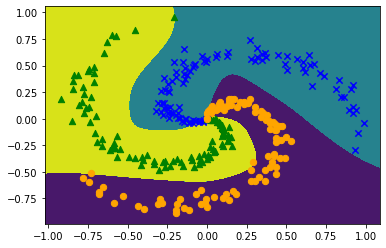

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
from dezero import Model
import dezero.functions as F
import dezero.layers as L
from dezero import DataLoader


max_epoch = 100
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for x, t in train_loader:
  print('x.shape',x.shape)
  print('t.shape',t.shape)

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        self.bn1 = L.BatchNorm()

    def forward(self, x):
        y = F.sigmoid(self.bn1(self.l1(x)))
        y = self.l2(y)
        return y


model = TwoLayerNet(hidden_size, 3)
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
    if epoch % 10 == 0:
        print('loss:', loss.data)

# Plot
x = np.array([example[0] for example in train_set])
t = np.array([example[1] for example in train_set])
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]

with dezero.test_mode():
    score = model(X)
predict_cls = np.argmax(score.data, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)

N, CLS_NUM = 100, 3
markers = ['o', 'x', '^']
colors = ['orange', 'blue', 'green']
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1],s=40,  marker=markers[c], c=colors[c])
plt.show()

# GPUを使う

In [ ]:
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, Dropout,BatchNormalization
from common.optimizer import RMSProp
from common.util import im2col, col2im

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from common.layers import TwoLayerNet
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import OrderedDict

class SimpleConvNetG:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']

        filter_num2 = conv_param['filter_num2']
        filter_num3 = conv_param['filter_num3']
        hidden_size2 = 128
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        # pool_output_pixel = filter_num3 * pool_output_size * pool_output_size # プーリング後のピクセル総数
        pool_output_pixel = 12544

        # Heを使う
        pre_node_nums = np.array([input_size*input_size,
                                filter_num2*filter_num,
                                filter_num2*filter_num2,
                                filter_num3*filter_num2,
                                filter_num3*filter_num3,
                                pool_output_pixel,
                                hidden_size,
                                hidden_size2
                                ])
        wi_scales = np.sqrt(2/pre_node_nums)

        print(wi_scales)

        # 重みの初期化
        self.params = {}
        std = weight_init_std
        # 64
        self.params['W1'] = wi_scales[0] * np.random.randn(filter_num, input_dim[0], filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b1'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        self.params['W12'] = wi_scales[1] * np.random.randn(filter_num, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b12'] = np.zeros(filter_num) #b1は畳み込みフィルターのバイアスになる
        # 128
        self.params['W21'] = wi_scales[2] * np.random.randn(filter_num2, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b21'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        self.params['W22'] = wi_scales[3] * np.random.randn(filter_num2, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b22'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        # 256
        self.params['W31'] = wi_scales[4] * np.random.randn(filter_num3, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b31'] = np.zeros(filter_num3) #b1は畳み込みフィルターのバイアスになる


        self.params['W2'] = wi_scales[2] *  np.random.randn(pool_output_pixel, hidden_size)
        print(wi_scales[1],pool_output_pixel,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = wi_scales[6] *  np.random.randn(hidden_size, hidden_size2)
        self.params['b3'] = np.zeros(hidden_size2)
        self.params['W4'] = wi_scales[7] *  np.random.randn(hidden_size2, output_size)
        self.params['b4'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv2d(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        
        self.layers['Conv2'] = Conv2d(self.params['W12'], self.params['b12'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        # self.layers['BatchNorm1'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv3'] = Conv2d(self.params['W21'], self.params['b21'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU3'] = ReLU()
        
        self.layers['Conv4'] = Conv2d(self.params['W22'], self.params['b22'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU4'] = ReLU()
        # self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        # self.layers['BatchNorm2'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv5'] = Conv2d(self.params['W31'], self.params['b31'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU5'] = ReLU()
        # self.layers['Pool3'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        # self.layers['BatchNorm3'] = BatchNormalization(gamma=1,beta=0)


        # self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)

        self.layers['Affine1'] = AffineG(self.params['W2'], self.params['b2'])
        self.layers['BatchNorm3'] = BatchNormalization(gamma=1,beta=0)
        self.layers['ReLU2'] = ReLU()
        # self.layers['Dropout1'] = Dropout(dropout_ratio=0.5)
        self.layers['Affine2'] = AffineG(self.params['W3'], self.params['b3'])
        self.layers['ReLU4'] = ReLU()
        self.layers['Dropout2'] = Dropout(dropout_ratio=0.5)
        
        self.layers['Affine3'] = AffineG(self.params['W4'], self.params['b4'])
        self.layers['ReLU4'] = ReLU()

        self.last_layer = SoftmaxWithLossG()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            # print('predict x.shape',x.shape)

        return x

    def loss(self, x, t):
        """
        損失関数
        """        
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        # print('dout.shape',dout.shape)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # print('layer.backward(dout)',dout.shape)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W21'], grads['b21'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W22'], grads['b22'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['W31'], grads['b31'] = self.layers['Conv5'].dW, self.layers['Conv5'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [ ]:
# CNNのオブジェクト生成
snet = SimpleConvNetG(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':32, 'filter_num2':64, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=15, weight_init_std=0.01)

epochs = 5
batch_size = 32
model = snet

xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

# Adamを使う
# optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam
optimizer = RMSProp(lr=0.001, rho=0.88)

train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

[0.05050763 0.03125    0.02209709 0.02209709 0.02209709 0.01262691
 0.14142136 0.14142136]
0.03125 12544 100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


t_loss 119.487 ------------- ,t_acc 65.167
t_loss 89.229 ------------- ,t_acc 75.167
t_loss 88.468 ------------- ,t_acc 77.000
t_loss 77.227 ------------- ,t_acc 81.000
t_loss 69.446 ------------- ,t_acc 84.167


In [ ]:
epochs = 5
train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 67.104 ------------- ,t_acc 84.833
t_loss 70.229 ------------- ,t_acc 83.167
t_loss 64.953 ------------- ,t_acc 84.000
t_loss 66.077 ------------- ,t_acc 84.167
t_loss 66.500 ------------- ,t_acc 81.333


# 99.8%精度

In [ ]:
from common.layers import Convolution, MaxPooling, ReLU, Affine, SoftmaxWithLoss, Dropout,BatchNormalization
from common.optimizer import RMSProp
from common.util import im2col, col2im

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import OrderedDict

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':16, 'filter_num2':32, 'filter_num3':64, 'filter_size':3, 'pad':0, 'stride':1},
                 pool_param={'pool_size':2, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
                
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        pool_size = pool_param['pool_size']
        pool_pad = pool_param['pad']
        pool_stride = pool_param['stride']

        filter_num2 = conv_param['filter_num2']
        filter_num3 = conv_param['filter_num3']
        
        input_size = input_dim[1]
        conv_output_size = (input_size + 2*filter_pad - filter_size) // filter_stride + 1 # 畳み込み後のサイズ(H,W共通)
        pool_output_size = (conv_output_size + 2*pool_pad - pool_size) // pool_stride + 1 # プーリング後のサイズ(H,W共通)
        pool_output_pixel = 1568

        # Heを使う
        pre_node_nums = np.array([filter_num*input_dim[0]*filter_num,
                                  filter_num2*filter_num3*filter_num,
                                  filter_num2*filter_num3*filter_num,
                                  filter_num3*filter_num2*filter_num,
                                  filter_num3*filter_num2,
                                  pool_output_pixel,
                                  hidden_size
                                  ])
        wi_scales = np.sqrt(2/pre_node_nums)

        # 重みの初期化
        self.params = {}
        std = weight_init_std
        # 16
        self.params['W1'] = wi_scales[0] * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num) 
        self.params['W12'] = wi_scales[1] * np.random.randn(filter_num, filter_num, filter_size, filter_size)
        self.params['b12'] = np.zeros(filter_num)
        # 32
        self.params['W21'] = wi_scales[2] * np.random.randn(filter_num2, filter_num, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b21'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる
        self.params['W22'] = wi_scales[3] * np.random.randn(filter_num2, filter_num2, filter_size, filter_size) # W1は畳み込みフィルターの重みになる
        self.params['b22'] = np.zeros(filter_num2) #b1は畳み込みフィルターのバイアスになる

        self.params['W2'] = wi_scales[5] *  np.random.randn(pool_output_pixel, hidden_size)
        print(wi_scales[1],pool_output_pixel,hidden_size)
        self.params['b2'] = np.zeros(hidden_size)

        self.params['W4'] = wi_scales[6] *  np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU1'] = ReLU()
        
        self.layers['Conv2'] = Convolution(self.params['W12'], self.params['b12'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        # self.layers['BatchNorm1'] = BatchNormalization(gamma=1,beta=0)

        self.layers['Conv3'] = Convolution(self.params['W21'], self.params['b21'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU3'] = ReLU()
        
        self.layers['Conv4'] = Convolution(self.params['W22'], self.params['b22'],
                                           conv_param['stride'], conv_param['pad']) # W1が畳み込みフィルターの重み, b1が畳み込みフィルターのバイアスになる
        self.layers['ReLU4'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_size, pool_w=pool_size, stride=pool_stride, pad=pool_pad)
        # self.layers['BatchNorm2'] = BatchNormalization(gamma=1,beta=0)


        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['ReLU5'] = ReLU()
        self.layers['BatchNorm2'] = BatchNormalization(gamma=1,beta=0)
        # self.layers['Dropout1'] = Dropout(dropout_ratio=0.5)
        self.layers['Affine3'] = Affine(self.params['W4'], self.params['b4'])
        # self.layers['ReLU6'] = ReLU()
        # self.layers['Dropout1'] = Dropout(dropout_ratio=0.5)
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """
        損失関数
        """        
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝播法）
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W12'], grads['b12'] = self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['W21'], grads['b21'] = self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W22'], grads['b22'] = self.layers['Conv4'].dW, self.layers['Conv4'].db
        # grads['W31'], grads['b31'] = self.layers['Conv5'].dW, self.layers['Conv5'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        # grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W4'], grads['b4'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [ ]:
# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':32, 'filter_num2':32, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=100, output_size=15, weight_init_std=0.01)

epochs = 3
batch_size = 32
model = snet

xsize = x.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

optimizer = RMSProp(lr=0.001, rho=0.88)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    # print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        # print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # print('x_train.shape',x_train.shape)
        # print('t_train.shape',t_train.shape)
        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録  
    l_loss = snet.loss(x,  t)

    train_loss.append(l_loss)
    X_test = X_test.reshape(-1,1,28,28)
    test_loss.append(snet.loss(X_test, y_test))
    train_accuracy.append(snet.accuracy(x, t))
    
    t_accuracy = snet.accuracy(X_test, y_test)
    test_accuracy.append(t_accuracy)

    print('loss,test_accuracy',l_loss, t_accuracy)

0.005524271728019903 1568 100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


loss,test_accuracy 0.5194852638198059 0.86
loss,test_accuracy 0.3156582874884778 0.9083333333333333
loss,test_accuracy 0.18400175024581242 0.925


In [ ]:
gen_train_data.shape

(3400, 1, 28, 28)

In [ ]:
X_train.shape

(1200, 1, 28, 28)

In [ ]:
# 7回、99.889の精度
x = np.concatenate([X_train, gen_train_data[:3000]])
t = np.concatenate([y_train, gen_train_label[:3000]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

In [ ]:
# 7回、98.889の精度
x = np.concatenate([X_train, gen_train_data[9000:12000]])
t = np.concatenate([y_train, gen_train_label[9000:12000]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

(6000, 1, 28, 28)

In [ ]:
# 20回、70の精度
x = np.concatenate([X_train, gen_train_data[6000:9000]])
t = np.concatenate([y_train, gen_train_label[6000:9000]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

拡張したデータと結合したｘ (4200, 1, 28, 28)
拡張したデータと結合したｘ (4200, 15)


In [ ]:
# 3回、100の精度
x = np.concatenate([X_train, gen_train_data[3000:6000]])
t = np.concatenate([y_train, gen_train_label[3000:6000]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

拡張したデータと結合したｘ (4200, 1, 28, 28)
拡張したデータと結合したｘ (4200, 15)


In [ ]:
# t_loss 1.474 ------------- ,t_acc 99.722
x = np.concatenate([X_train, gen_train_data[4500:7500]])
t = np.concatenate([y_train, gen_train_label[4500:7500]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

拡張したデータと結合したｘ (4200, 1, 28, 28)
拡張したデータと結合したｘ (4200, 15)


In [ ]:
# 
ox = np.concatenate([X_train, X_test])
ot = np.concatenate([y_train, y_test])
print('拡張したデータと結合したｘ',ox.shape)
print('拡張したデータと結合したｘ',ot.shape)

拡張したデータと結合したｘ (3000, 1, 28, 28)
拡張したデータと結合したｘ (3000, 15)


In [ ]:
x.shape

(2400, 1, 28, 28)

In [ ]:
X_test.shape

(600, 1, 28, 28)

In [ ]:
# 
x = np.concatenate([X_train, gen_train_data[7500:10500]])
t = np.concatenate([y_train, gen_train_label[7500:10500]])
print('拡張したデータと結合したｘ',x.shape)
print('拡張したデータと結合したｘ',t.shape)

拡張したデータと結合したｘ (4200, 1, 28, 28)
拡張したデータと結合したｘ (4200, 15)


t_loss 172.268 ------------- ,t_acc 44.833
t_loss 166.816 ------------- ,t_acc 47.333
t_loss 159.707 ------------- ,t_acc 48.500


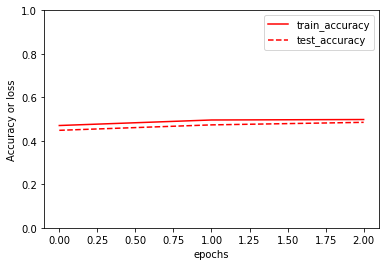

In [ ]:
epochs = 3
optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 20.425 ------------- ,t_acc 94.167
t_loss 21.243 ------------- ,t_acc 93.167
t_loss 20.407 ------------- ,t_acc 95.333


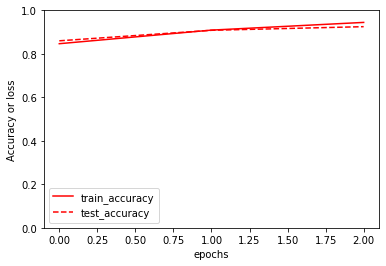

In [ ]:
epochs = 3
optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 20.904 ------------- ,t_acc 95.167
t_loss 20.549 ------------- ,t_acc 95.667
t_loss 22.533 ------------- ,t_acc 93.833
t_loss 17.237 ------------- ,t_acc 94.833
t_loss 18.055 ------------- ,t_acc 94.833
t_loss 16.443 ------------- ,t_acc 95.167
t_loss 19.122 ------------- ,t_acc 95.667
t_loss 16.980 ------------- ,t_acc 95.667
t_loss 17.006 ------------- ,t_acc 95.333
t_loss 18.032 ------------- ,t_acc 95.167


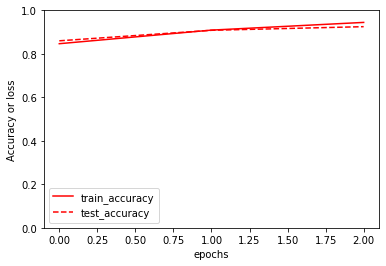

In [ ]:
epochs = 10
optimizer = Adam(lr=0.0001, beta1=0.81, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

In [ ]:
x.shape

(2400, 1, 28, 28)

In [ ]:
# dic_katakana = {"a":0,"i":1,"u":2,"e":3,"o":4,"ka":5,"ki":6,"ku":7,"ke":8,"ko":9,"sa":10,"si":11,"su":12,"se":13,"so":14}
y_pred = snet.predict(x)
# plot_ConfMat(y_pred,t)

In [ ]:
snet.accuracy(x,t,600)

0.99875

In [ ]:
snet.accuracy(X_train,y_train,600)

0.99875

In [ ]:
x.shape

(2400, 1, 28, 28)

0.005524271728019903 1568 128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


t_loss 79.034 ------------- ,t_acc 82.833
t_loss 45.591 ------------- ,t_acc 91.167
t_loss 32.374 ------------- ,t_acc 94.167
t_loss 23.717 ------------- ,t_acc 95.333
t_loss 17.901 ------------- ,t_acc 97.500


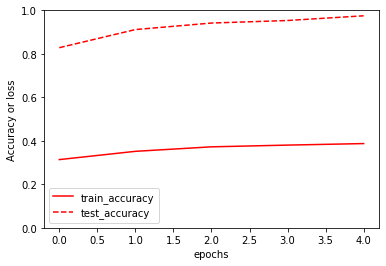

In [ ]:
# CNNのオブジェクト生成
snet = SimpleConvNet(input_dim=(1, 28, 28), 
                     conv_param={'filter_num':32, 'filter_num2':32, 'filter_num3':64,'filter_size':3, 'pad':1, 'stride':1},
                     pool_param={'pool_size':2, 'pad':0, 'stride':2},
                     hidden_size=128, output_size=15, weight_init_std=0.01)

epochs = 5
optimizer = Adam(lr=0.0001, beta1=0.81, beta2=0.98) #Adam
train(snet, optimizer,epochs,gen_train_data[:3000],gen_train_label[:3000],X_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


t_loss 15.153 ------------- ,t_acc 98.000
t_loss 12.787 ------------- ,t_acc 98.333
t_loss 10.480 ------------- ,t_acc 98.500
t_loss 8.415 ------------- ,t_acc 98.833
t_loss 6.589 ------------- ,t_acc 99.667


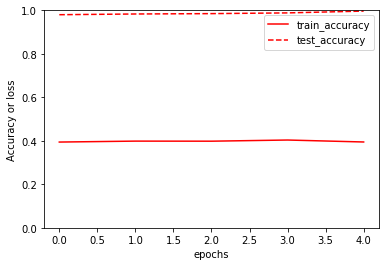

In [ ]:
epochs = 5
train(snet, optimizer,epochs,gen_train_data[:3000],gen_train_label[:3000],X_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


t_loss 6.066 ------------- ,t_acc 99.375
t_loss 6.039 ------------- ,t_acc 99.458
t_loss 5.076 ------------- ,t_acc 99.583
t_loss 4.388 ------------- ,t_acc 99.875
t_loss 3.511 ------------- ,t_acc 99.917


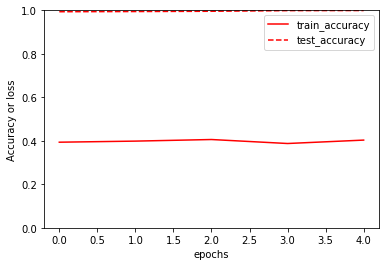

In [ ]:
epochs = 5
train(snet, optimizer,epochs,gen_train_data[:3000],gen_train_label[:3000],X_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


t_loss 3.980 ------------- ,t_acc 99.917
t_loss 3.959 ------------- ,t_acc 99.750
t_loss 3.763 ------------- ,t_acc 99.750
t_loss 3.494 ------------- ,t_acc 99.750
t_loss 3.218 ------------- ,t_acc 99.750


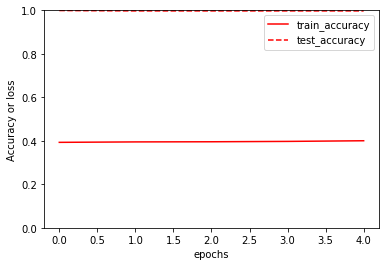

In [ ]:
epochs = 5
train(snet, optimizer,epochs,gen_train_data[3000:6000],gen_train_label[3000:6000],X_train,y_train)

t_loss 13.896 ------------- ,t_acc 98.583
t_loss 12.268 ------------- ,t_acc 98.792
t_loss 12.212 ------------- ,t_acc 98.750


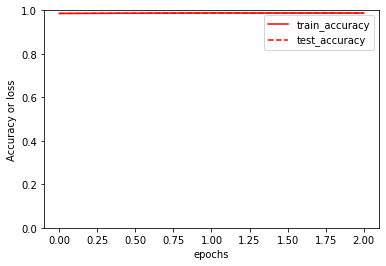

In [ ]:
epochs = 3
# optimizer = Adam(lr=0.0001, beta1=0.81, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,x,t,X_train,y_train)

t_loss 18.008 ------------- ,t_acc 96.667
t_loss 16.901 ------------- ,t_acc 97.000
t_loss 18.032 ------------- ,t_acc 96.667
t_loss 16.513 ------------- ,t_acc 97.333
t_loss 16.391 ------------- ,t_acc 96.667


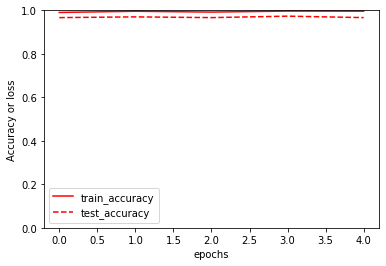

In [ ]:
epochs = 5
# optimizer = Adam(lr=0.0001, beta1=0.83, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

In [ ]:
epochs = 5
# optimizer = Adam(lr=0.0001, beta1=0.81, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,gen_train_data[:6000],gen_train_label[:6000],X_test,y_test)

t_loss 22.403 ------------- ,t_acc 96.167
t_loss 19.006 ------------- ,t_acc 97.167
t_loss 17.504 ------------- ,t_acc 97.167
t_loss 16.777 ------------- ,t_acc 97.000
t_loss 15.389 ------------- ,t_acc 97.167


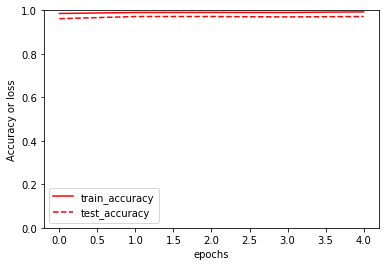

In [ ]:
epochs = 5
# optimizer = Adam(lr=0.0001, beta1=0.81, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,ox,ot,X_test,y_test)

t_loss 46.786 ------------- ,t_acc 91.667
t_loss 41.481 ------------- ,t_acc 94.167
t_loss 45.153 ------------- ,t_acc 93.333
t_loss 48.347 ------------- ,t_acc 92.667
t_loss 47.003 ------------- ,t_acc 91.500


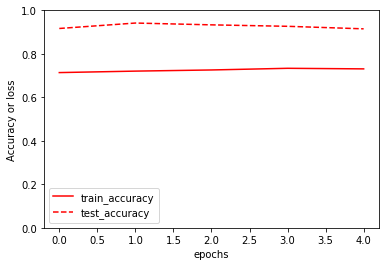

In [ ]:
epochs = 5
train(snet, optimizer,epochs,iter_num,gen_train_data,gen_train_label,X_test,y_test)

In [ ]:
gen_train_data.shape

(3400, 1, 28, 28)

In [ ]:
epochs = 2
optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 2.457 ------------- ,t_acc 99.778
t_loss 1.639 ------------- ,t_acc 99.778


In [ ]:
epochs = 10
optimizer = Adam(lr=0.0001, beta1=0.8, beta2=0.98) #Adam
# optimizer = RMSProp(lr=0.001, rho=0.88)
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 28.227 ------------- ,t_acc 95.500
t_loss 28.375 ------------- ,t_acc 95.333
t_loss 25.024 ------------- ,t_acc 96.000
t_loss 25.489 ------------- ,t_acc 95.111
t_loss 24.485 ------------- ,t_acc 95.833
t_loss 27.064 ------------- ,t_acc 95.556
t_loss 23.176 ------------- ,t_acc 96.222
t_loss 21.837 ------------- ,t_acc 96.111
t_loss 24.102 ------------- ,t_acc 94.944
t_loss 25.883 ------------- ,t_acc 95.111


In [ ]:
epochs = 10
optimizer = Adam(lr=0.0001, beta1=0.9, beta2=0.99) #Adam
# optimizer = RMSProp(lr=0.001, rho=0.88)
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 26.255 ------------- ,t_acc 94.333
t_loss 26.665 ------------- ,t_acc 93.722
t_loss 25.819 ------------- ,t_acc 92.889
t_loss 26.950 ------------- ,t_acc 93.833
t_loss 22.126 ------------- ,t_acc 95.444
t_loss 23.351 ------------- ,t_acc 94.389
t_loss 25.699 ------------- ,t_acc 93.444
t_loss 24.464 ------------- ,t_acc 93.611
t_loss 25.103 ------------- ,t_acc 93.389
t_loss 21.652 ------------- ,t_acc 95.222


In [ ]:
epochs = 10
optimizer = Adam(lr=0.0001, beta1=0.75, beta2=0.9) #Adam
# optimizer = RMSProp(lr=0.001, rho=0.88)
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 22.984 ------------- ,t_acc 93.833
t_loss 22.111 ------------- ,t_acc 93.611
t_loss 23.760 ------------- ,t_acc 93.000
t_loss 26.139 ------------- ,t_acc 92.944
t_loss 22.413 ------------- ,t_acc 93.500
t_loss 23.253 ------------- ,t_acc 93.722
t_loss 25.576 ------------- ,t_acc 93.222
t_loss 22.348 ------------- ,t_acc 93.500
t_loss 22.701 ------------- ,t_acc 94.389
t_loss 23.304 ------------- ,t_acc 93.944


In [ ]:
epochs = 2
optimizer = Adam(lr=0.0001, beta1=0.81, beta2=0.98) #Adam
# optimizer = RMSProp(lr=0.001, rho=0.88)
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 3.450 ------------- ,t_acc 98.889
t_loss 3.204 ------------- ,t_acc 99.167


In [ ]:
epochs = 3
train(snet, optimizer,epochs,iter_num,x,t,X_test,y_test)

t_loss 1.902 ------------- ,t_acc 99.333
t_loss 2.059 ------------- ,t_acc 98.944
t_loss 2.469 ------------- ,t_acc 99.111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


t_loss 12.526 ------------- ,t_acc 99.250
t_loss 6.857 ------------- ,t_acc 99.250
t_loss 5.157 ------------- ,t_acc 99.917
t_loss 4.174 ------------- ,t_acc 99.917
t_loss 3.538 ------------- ,t_acc 99.958


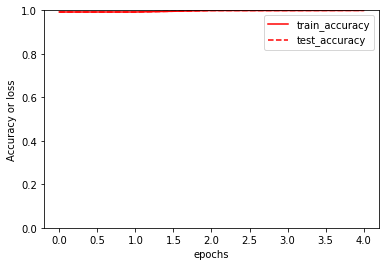

In [ ]:
epochs = 5
train(snet, optimizer,epochs,x,t,X_train,y_train)

In [ ]:
epochs = 15
train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

In [ ]:
epochs = 15
train(model, optimizer,epochs,iter_num,x,t,X_test,y_test)

In [ ]:
epochs = 3

for epoch in range(epochs):
    # print("epoch=%s"%epoch)

    # シャッフル
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        """
        ランダムなミニバッチを順番に取り出す
        """
        # print("it=", it)
        mask = idx[batch_size*it : batch_size*(it+1)]

        # ミニバッチの生成
        x_train = x[mask]
        t_train = t[mask]

        # print('x_train.shape',x_train.shape)
        # print('t_train.shape',t_train.shape)
        # 勾配の計算 (誤差逆伝播法を用いる) 
        grads = snet.gradient(x_train, t_train)

        # 更新
        optimizer.update(snet.params, grads)

    ## 学習経過の記録  
    l_loss = snet.loss(x,  t)

    train_loss.append(l_loss)
    X_test = X_test.reshape(-1,1,28,28)
    test_loss.append(snet.loss(X_test, y_test))
    train_accuracy.append(snet.accuracy(x, t))
    
    t_accuracy = snet.accuracy(X_test, y_test)
    test_accuracy.append(t_accuracy)

    print('loss,test_accuracy',l_loss, t_accuracy)

loss,test_accuracy 0.008928460036417297 0.9916666666666667
loss,test_accuracy 0.011101360349715454 0.995
loss,test_accuracy 0.009741163713377311 0.9916666666666667


In [ ]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(snet, f)

PicklingError: ignored

In [ ]:
x.shape

(8400, 1, 28, 28)

In [ ]:
try:
    import cupy as cp
    cupy = cp
except ImportError:
    gpu_enable = False  

def get_array_module(x):
    """Returns the array module for `x`.

    Args:
        x (dezero.Variable or numpy.ndarray or cupy.ndarray): Values to
            determine whether NumPy or CuPy should be used.

    Returns:
        module: `cupy` or `numpy` is returned based on the argument.
    """
    xp = cp.get_array_module(x)
    return xp

class AffineG:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        xp = get_array_module(x)
        # テンソル対応(画像形式のxに対応させる)
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = xp.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        xp = get_array_module(dout)
        dx = xp.dot(dout, self.W.T)
        self.dW = xp.dot(self.x.T, dout)
        self.db = xp.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

class ReLUG:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        xp = get_array_module(x)
        out = xp.maximum(x, 0.0)
        # self.mask = (x <= 0)
        # out = x.copy()
        # out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

def softmax(x):
    xp = get_array_module(x)
    if x.ndim == 2:
        x = x.T
        x = x - xp.max(x, axis=0)
        y = xp.exp(x) / xp.sum(xp.exp(x), axis=0)
        return y.T 

    x = x - xp.max(x) # オーバーフロー対策
    return xp.exp(x) / xp.sum(xp.exp(x))                

class SoftmaxWithLossG:
    def __init__(self):
        
        # 初期値
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        """
        順伝播
        """
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        """
        逆伝播
        伝播する値をバッチサイズで割ること
        dout=1は、他のレイヤと同じ使い方ができるように設定しているダミー変数
        """
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

def cross_entropy_error(y, t):
    """
    y : 出力値(通常は、0-1の確率)  
    t : 正解値(通常は、0or1)  
    """
    xp = get_array_module(t)

    if y.ndim==1:
        t = t.reshape(1, -1)
        y = y.reshape(1, -1)
        
    batch_size = y.shape[0]
    delta = 1e-7
    return -xp.sum( t * xp.log(y + delta)) / batch_size

# class Softmax(Function):
#     def __init__(self, axis=1):
#         self.axis = axis

#     def forward(self, x):
#         xp = get_array_module(x)
#         y = x - x.max(axis=self.axis, keepdims=True)
#         y = xp.exp(y)
#         y /= y.sum(axis=self.axis, keepdims=True)
#         return y

#     def backward(self, gy):
#         y = self.outputs[0]()
#         gx = y * gy
#         sumdx = gx.sum(axis=self.axis, keepdims=True)
#         gx -= y * sumdx
#         return gx        

class Conv2d:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W # フィルターの重み(配列形状:フィルターの枚数, チャンネル数, フィルターの高さ, フィルターの幅)
        self.b = b #フィルターのバイアス
        self.stride = stride # ストライド数
        self.pad = pad # パディング数
        
        # インスタンス変数の宣言
        self.x = None   
        self.col = None
        self.col_W = None
        self.dcol = None
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        順伝播計算
        x : 入力(配列形状=(データ数, チャンネル数, 高さ, 幅))
        """
        xp = get_array_module(x) #CUPYを使う　　GPU！！！

        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = (H + 2*self.pad - FH) // self.stride + 1 # 出力の高さ(端数は切り捨てる)
        out_w =(W + 2*self.pad - FW) // self.stride + 1# 出力の幅(端数は切り捨てる)

        # 畳み込み演算を効率的に行えるようにするため、入力xを行列colに変換する
        col = im2col(x, FH, FW, self.stride, self.pad)
        
        # 重みフィルターを2次元配列に変換する
        # col_Wの配列形状は、(C*FH*FW, フィルター枚数)
        col_W = self.W.reshape(FN, -1).T

        # 行列の積を計算し、バイアスを足す
        # out = np.dot(col, col_W) + self.b
        out = xp.dot(col, col_W) + self.b
        
        # 画像形式に戻して、チャンネルの軸を2番目に移動させる
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        xp = get_array_module(dout) #CUPYを使う　　GPU！！！
        """
        逆伝播計算
        Affineレイヤと同様の考え方で、逆伝播させる
        dout : 出力層側の勾配
        return : 入力層側へ伝える勾配
        """
        FN, C, FH, FW = self.W.shape
        
        # doutのチャンネル数軸を4番目に移動させ、2次元配列に変換する
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        # バイアスbはデータ数方向に総和をとる
        # self.db = np.sum(dout, axis=0)
        self.db = xp.sum(dout, axis=0)
        
        # 重みWは、入力である行列colと行列doutの積になる
        # self.dW = np.dot(self.col.T, dout)
        self.dW = xp.dot(self.col.T, dout)
        
        # (フィルター数, チャンネル数, フィルター高さ、フィルター幅)の配列形状に戻す
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        # 入力側の勾配は、doutにフィルターの重みを掛けて求める
        # dcol = np.dot(dout, self.col_W.T)
        dcol = xp.dot(dout, self.col_W.T)
        
        # 勾配を4次元配列(データ数, チャンネル数, 高さ, 幅)に変換する
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad, is_backward=True)

        self.dcol = dcol # 結果を確認するために保持しておく
            
        return dx

# tensorflowを使う

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2400, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (600, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [ ]:
x = X_train[:10000,:].reshape(-1,28,28,1) # 配列形式の変形
t = y_train[:10000,:]

X_test = X_test[:10000,:].reshape(-1,28,28,1) 
y_test = y_test[:10000,:]

In [ ]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(15, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x, t, epochs=10)

In [ ]:
model.fit(x, t, epochs=15)

In [ ]:
epochs = 20
batch_size = 128
train_steps = x.shape[0] // batch_size
valid_steps = t.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
# Fit the model
history = model.fit(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = (X_test, y_test),
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

In [ ]:
# epoch = 20, model.compile=10, validation_dataが拡張しなかった
history = model.fit(nx, nt, validation_split=0.2, epochs=50, batch_size=128, verbose=1)

In [ ]:
nx=np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
nt=np.concatenate([train_gen.next()[1] for i in range(train_gen.__len__())])
print(nx.shape)
print(nt.shape)

nx = nx.reshape(-1,28,28,1)

(2400, 1, 28, 28)
(2400, 15)


In [ ]:
nx = nx.reshape(-1,28,28,1)

In [ ]:
nx.shape

(2400, 28, 28, 1)

In [ ]:
X_test.shape

(600, 28, 28, 1)

In [ ]:
# epoch = 20, model.compile=10, validation_dataが拡張しなかった
test_loss, test_acc = model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 7.6763 - accuracy: 0.0733


# 層を減らす